# Overview

In this competition, we benchmark machine learning models on a challenging large-scale dataset. The data comes from Vesta's real-world e-commerce transactions and contains a wide range of features from device type to product features. We also have the opportunity to create new features to improve your results.

See the [README](README.md) for further details

## Approach

In this notebook, we leverage a custom API, [JLpyUtils](https://pypi.org/project/JLpyUtils/), the author ([John Leonard](https://www.linkedin.com/in/johntleonard/)) has developed to streamline exploritory data analysis, feature engineering, and model selection tasks. Furthermore, we heavily utilize the [dask](https://dask.org), as it is much more efficient at managing large datasets such as those used in this analysis. To further improve our memory resource management, we often use python manual garbage collection function ```gc.collect()``` to clear out deleted objects from memory.

# Install Libs

In [1]:
!pip install --upgrade JLpyUtils

import IPython.display
IPython.display.clear_output()

# Import Libs

In [1]:
import numpy as np
import pandas as pd
import sys, os, importlib, gc
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings

import dask
import dask_xgboost
import dask_ml, dask_ml.model_selection

In [2]:
pd.options.display.max_columns = 1000
mpl.rcParams['font.size']=14

In [3]:
dev = True

In [4]:
path_desktop = os.path.abspath('..')
if dev:
    print('Running in dev mode. Using local copy of JLpyUtils')
    path_dev_repo = os.path.join(path_desktop,'JLpyUtils')
    sys.path.insert(0, path_dev_repo)

import JLpyUtils

Running in dev mode. Using local copy of JLpyUtils


In [5]:
JLpyUtils.__version__

'0.2.17'

# Download Raw Data

This competion uses train test sets that are >100 mb, which is githubs standard limit, thus we don't store the dataset directly in the repo.. Below, we download the data from kaggle URL specified at the competition home page

In [6]:
competition = 'ieee-fraud-detection'
path_report_dir = os.path.join(path_desktop,'outputs','Project_Kaggle_IEEE-CIS_Fraud_Detection')
path_raw_data_dir = os.path.join(path_report_dir,competition)

In [7]:
# JLpyUtils.kaggle.setup_config_dir(username='jleona01', 
#                                   key='a54480ae85b680f8c9b1dde5b244c95e')

# JLpyUtils.kaggle.competition_download_files(competition, path_report_dir)

# Load Data

In [8]:
def load_df(path_raw_data_dir,
            train_test_id = 'train'):
    """
    Load the train or test df by left joining the transaction data with the identity data on the 'TransactionID' header
    """
    import gc 
    
    import dask.dataframe as dd
    
    df_transaction = dd.read_csv(os.path.join( path_raw_data_dir, train_test_id+'_transaction.csv'))
    df_identity = dd.read_csv(os.path.join( path_raw_data_dir, train_test_id+'_identity.csv'))
    
    df = dd.merge(df_transaction, df_identity, how='left', on = 'TransactionID')



    
    del df_transaction, df_identity
    gc.collect()
    return df

df = load_df(path_raw_data_dir, 
             train_test_id = 'train')
display(df.info())
display(df.head(), df.shape)

<class 'dask.dataframe.core.DataFrame'>
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: object(31), float64(399), int64(4)

None

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0

(Delayed('int-8cbcc934-3ca5-42ef-bc4c-86f69a53dadd'), 434)

# Define Feature and Label headers

In [9]:
def fetch_headers_dict():
    headers_dict = {'labels':['isFraud'],
                    'UID':'TransactionID'}
    headers_dict['features'] = list(df.drop(columns=headers_dict['labels']+ [headers_dict['UID']]).columns)
    headers_dict['categorical features'] = ['ProductCD']+[header for header in headers_dict['features'] if 'card' in header or 'addr' in header or 'emaildomain' in header or 'M' in header or 'Device' in header and header != headers_dict['UID']] + ['id_'+str(int_) for int_ in range(12,39)]
    headers_dict['continuous features'] = [feature for feature in headers_dict['features'] if feature not in headers_dict['categorical features']]
    return headers_dict

headers_dict = fetch_headers_dict()
for key in headers_dict.keys():
    print('\n',key,':', headers_dict[key])


 labels : ['isFraud']

 UID : TransactionID

 features : ['TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 

# Define X and Y

In [10]:
X = df[headers_dict['features']]
y = df[headers_dict['labels']]

# Basic Feature Cleaning

In [11]:
def basic_feat_cleaner(X):
    import warnings
    warnings.filterwarnings('ignore')
    
    X['M1'] = X['M1'].fillna('F')
    
    warnings.filterwarnings('default')
    return X

X = basic_feat_cleaner(X)

# EDA

In [33]:
importlib.reload(JLpyUtils.ML.inspection)
importlib.reload(JLpyUtils.ML.inspection._unique)
importlib.reload(JLpyUtils.ML.inspection)
importlib.reload(JLpyUtils.ML.inspection._unique)

JLpyUtils.ML.inspection.uniques(X)


---- TransactionDT ---- 
n_uniques: 573349 
dtype: int64

uniques[:20]:


[86400,
 86401,
 86469,
 86499,
 86506,
 86510,
 86522,
 86529,
 86535,
 86536,
 86549,
 86555,
 86564,
 86585,
 86596,
 86618,
 86620,
 86668,
 86725,
 86730,
 '...']


---- card1 ---- 
n_uniques: 13553 
dtype: int64

uniques[:20]:


[1000,
 1001,
 1004,
 1005,
 1006,
 1007,
 1008,
 1009,
 1010,
 1011,
 1012,
 1013,
 1014,
 1015,
 1016,
 1018,
 1020,
 1021,
 1022,
 1023,
 '...']


---- C1 ---- 
n_uniques: 1657 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- C10 ---- 
n_uniques: 1231 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- C11 ---- 
n_uniques: 1476 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- C12 ---- 
n_uniques: 1199 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- C13 ---- 
n_uniques: 1597 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- C14 ---- 
n_uniques: 1108 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- C2 ---- 
n_uniques: 1216 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- C3 ---- 
n_uniques: 27 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- C4 ---- 
n_uniques: 1260 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- C5 ---- 
n_uniques: 319 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- C6 ---- 
n_uniques: 1328 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- C7 ---- 
n_uniques: 1103 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- C8 ---- 
n_uniques: 1253 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- C9 ---- 
n_uniques: 205 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- D1 ---- 
n_uniques: 642 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- D10 ---- 
n_uniques: 819 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- D11 ---- 
n_uniques: 677 
dtype: float64

uniques[:20]:


[-53.0,
 -33.0,
 -29.0,
 -28.0,
 -15.0,
 -13.0,
 -7.0,
 0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 '...']


---- D12 ---- 
n_uniques: 636 
dtype: float64

uniques[:20]:


[-83.0,
 -74.0,
 0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 '...']


---- D13 ---- 
n_uniques: 578 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- D14 ---- 
n_uniques: 803 
dtype: float64

uniques[:20]:


[-193.0,
 -83.0,
 0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 '...']


---- D15 ---- 
n_uniques: 860 
dtype: float64

uniques[:20]:


[-83.0,
 -74.0,
 -60.0,
 -53.0,
 -30.0,
 -29.0,
 -28.0,
 -15.0,
 -13.0,
 -6.0,
 -3.0,
 -2.0,
 -1.0,
 0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 '...']


---- D2 ---- 
n_uniques: 642 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- D3 ---- 
n_uniques: 650 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- D4 ---- 
n_uniques: 809 
dtype: float64

uniques[:20]:


[-122.0,
 -90.0,
 -83.0,
 -74.0,
 -53.0,
 -42.0,
 -30.0,
 -28.0,
 -16.0,
 -15.0,
 -6.0,
 -2.0,
 -1.0,
 0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 '...']


---- D5 ---- 
n_uniques: 689 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- D6 ---- 
n_uniques: 830 
dtype: float64

uniques[:20]:


[-83.0,
 -74.0,
 -6.0,
 0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 '...']


---- D7 ---- 
n_uniques: 598 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- D8 ---- 
n_uniques: 12354 
dtype: float64

uniques[:20]:


[0.0,
 0.04166600108146668,
 0.08333300054073334,
 0.125,
 0.16666600108146667,
 0.20833300054073334,
 0.25,
 0.2916660010814667,
 0.3333329856395721,
 0.375,
 0.4166660010814667,
 0.4583329856395722,
 0.5,
 0.5416659712791443,
 0.5833330154418945,
 0.625,
 0.6666659712791443,
 0.7083330154418945,
 0.75,
 0.7916659712791443,
 '...']


---- D9 ---- 
n_uniques: 25 
dtype: float64

uniques[:20]:


[0.0,
 0.04166600108146668,
 0.08333300054073334,
 0.125,
 0.16666600108146667,
 0.20833300054073334,
 0.25,
 0.2916660010814667,
 0.3333329856395721,
 0.375,
 0.4166660010814667,
 0.4583329856395722,
 0.5,
 0.5416659712791443,
 0.5833330154418945,
 0.625,
 0.6666659712791443,
 0.7083330154418945,
 0.75,
 0.7916659712791443,
 '...']


---- TransactionAmt ---- 
n_uniques: 20902 
dtype: float64

uniques[:20]:


[0.251,
 0.272,
 0.292,
 0.35,
 0.364,
 0.424,
 0.467,
 0.484,
 0.498,
 0.499,
 0.5429999999999999,
 0.57,
 0.583,
 0.588,
 0.615,
 0.687,
 0.755,
 0.758,
 0.77,
 0.7859999999999999,
 '...']


---- V1 ---- 
n_uniques: 3 
dtype: float64

uniques[:]:


[0.0, 1.0, nan]


---- V10 ---- 
n_uniques: 6 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, nan]


---- V100 ---- 
n_uniques: 30 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V101 ---- 
n_uniques: 871 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V102 ---- 
n_uniques: 1286 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V103 ---- 
n_uniques: 929 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V104 ---- 
n_uniques: 17 
dtype: float64

uniques[:]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 nan]


---- V105 ---- 
n_uniques: 101 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V106 ---- 
n_uniques: 57 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V107 ---- 
n_uniques: 3 
dtype: float64

uniques[:]:


[0.0, 1.0, nan]


---- V108 ---- 
n_uniques: 9 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, nan]


---- V109 ---- 
n_uniques: 9 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, nan]


---- V11 ---- 
n_uniques: 7 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, nan]


---- V110 ---- 
n_uniques: 9 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, nan]


---- V111 ---- 
n_uniques: 11 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, nan]


---- V112 ---- 
n_uniques: 11 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, nan]


---- V113 ---- 
n_uniques: 11 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, nan]


---- V114 ---- 
n_uniques: 8 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, nan]


---- V115 ---- 
n_uniques: 8 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, nan]


---- V116 ---- 
n_uniques: 8 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, nan]


---- V117 ---- 
n_uniques: 5 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, nan]


---- V118 ---- 
n_uniques: 5 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, nan]


---- V119 ---- 
n_uniques: 5 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, nan]


---- V12 ---- 
n_uniques: 5 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, nan]


---- V120 ---- 
n_uniques: 5 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, nan]


---- V121 ---- 
n_uniques: 5 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, nan]


---- V122 ---- 
n_uniques: 5 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, nan]


---- V123 ---- 
n_uniques: 15 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, nan]


---- V124 ---- 
n_uniques: 15 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, nan]


---- V125 ---- 
n_uniques: 15 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, nan]


---- V126 ---- 
n_uniques: 10300 
dtype: float64

uniques[:20]:


[0.0,
 0.2915000021457672,
 0.4239999949932097,
 0.4668999910354614,
 0.7547000050544739,
 0.8781999945640564,
 0.8909000158309937,
 0.9571999907493592,
 1.0,
 1.000599980354309,
 1.3085999488830566,
 1.3149000406265259,
 1.7563999891281128,
 1.9143999814987185,
 2.0,
 2.1517999172210693,
 2.2960000038146973,
 2.336199998855591,
 2.4486000537872314,
 2.537600040435791,
 '...']


---- V127 ---- 
n_uniques: 24415 
dtype: float64

uniques[:20]:


[0.0,
 0.2915000021457672,
 0.4239999949932097,
 0.4668999910354614,
 0.7547000050544739,
 0.8781999945640564,
 0.8909000158309937,
 0.9571999907493592,
 1.0,
 1.000599980354309,
 1.3085999488830566,
 1.3149000406265259,
 1.7563999891281128,
 1.9143999814987185,
 1.9900000095367432,
 2.0,
 2.1517999172210693,
 2.2960000038146973,
 2.336199998855591,
 2.4486000537872314,
 '...']


---- V128 ---- 
n_uniques: 14508 
dtype: float64

uniques[:20]:


[0.0,
 0.2915000021457672,
 0.4239999949932097,
 0.4668999910354614,
 0.7547000050544739,
 0.8781999945640564,
 0.8909000158309937,
 0.9571999907493592,
 1.0,
 1.000599980354309,
 1.3085999488830566,
 1.3149000406265259,
 1.7563999891281128,
 1.9143999814987185,
 2.0,
 2.1517999172210693,
 2.2960000038146973,
 2.336199998855591,
 2.4486000537872314,
 2.537600040435791,
 '...']


---- V129 ---- 
n_uniques: 1969 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 3.3145999908447266,
 3.9876999855041504,
 4.023200035095215,
 4.547399997711182,
 4.672500133514403,
 4.833600044250488,
 4.897200107574463,
 5.0,
 5.0721001625061035,
 5.829999923706055,
 5.96999979019165,
 5.989999771118164,
 6.0,
 6.089700222015381,
 6.102399826049805,
 6.179800033569336,
 '...']


---- V13 ---- 
n_uniques: 8 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, nan]


---- V130 ---- 
n_uniques: 12333 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 2.537600040435791,
 3.0,
 3.2583999633789062,
 3.3145999908447266,
 3.9876999855041504,
 4.023200035095215,
 4.303599834442139,
 4.547399997711182,
 4.672500133514403,
 4.833600044250488,
 4.838900089263916,
 5.0,
 5.0721001625061035,
 5.196100234985352,
 5.215199947357178,
 5.596799850463867,
 5.829999923706055,
 '...']


---- V131 ---- 
n_uniques: 4445 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 3.3145999908447266,
 3.9876999855041504,
 4.023200035095215,
 4.303599834442139,
 4.547399997711182,
 4.672500133514403,
 4.833600044250488,
 4.838900089263916,
 5.0,
 5.0721001625061035,
 5.215199947357178,
 5.596799850463867,
 5.829999923706055,
 5.96999979019165,
 5.989999771118164,
 6.0,
 '...']


---- V132 ---- 
n_uniques: 6561 
dtype: float64

uniques[:20]:


[0.0,
 0.2915000021457672,
 0.4239999949932097,
 0.4668999910354614,
 0.7547000050544739,
 0.8781999945640564,
 0.8909000158309937,
 0.9571999907493592,
 1.0,
 1.000599980354309,
 1.3085999488830566,
 1.3149000406265259,
 1.7563999891281128,
 1.9143999814987185,
 2.4486000537872314,
 2.537600040435791,
 2.565200090408325,
 2.599600076675415,
 2.6171998977661133,
 2.6345999240875244,
 '...']


---- V133 ---- 
n_uniques: 9950 
dtype: float64

uniques[:20]:


[0.0,
 0.2915000021457672,
 0.4239999949932097,
 0.4668999910354614,
 0.7547000050544739,
 0.8781999945640564,
 0.8909000158309937,
 0.9571999907493592,
 1.0,
 1.000599980354309,
 1.3085999488830566,
 1.3149000406265259,
 1.7563999891281128,
 1.9143999814987185,
 1.9900000095367432,
 2.4486000537872314,
 2.537600040435791,
 2.565200090408325,
 2.599600076675415,
 2.6171998977661133,
 '...']


---- V134 ---- 
n_uniques: 8179 
dtype: float64

uniques[:20]:


[0.0,
 0.2915000021457672,
 0.4239999949932097,
 0.4668999910354614,
 0.7547000050544739,
 0.8781999945640564,
 0.8909000158309937,
 0.9571999907493592,
 1.0,
 1.000599980354309,
 1.3085999488830566,
 1.3149000406265259,
 1.7563999891281128,
 1.9143999814987185,
 2.4486000537872314,
 2.537600040435791,
 2.565200090408325,
 2.599600076675415,
 2.6171998977661133,
 2.6345999240875244,
 '...']


---- V135 ---- 
n_uniques: 3725 
dtype: float64

uniques[:20]:


[0.0,
 2.1517999172210693,
 2.2960000038146973,
 2.336199998855591,
 2.582200050354004,
 3.0125000476837163,
 3.383500099182129,
 3.497999906539917,
 3.731699943542482,
 3.9347000122070312,
 3.9967000484466553,
 4.39900016784668,
 4.48799991607666,
 4.611000061035156,
 4.833600044250488,
 4.96999979019165,
 5.0,
 5.014900207519531,
 5.13040018081665,
 5.348800182342528,
 '...']


---- V136 ---- 
n_uniques: 4853 
dtype: float64

uniques[:20]:


[0.0,
 2.1517999172210693,
 2.2960000038146973,
 2.336199998855591,
 2.582200050354004,
 3.0125000476837163,
 3.383500099182129,
 3.497999906539917,
 3.731699943542482,
 3.9347000122070312,
 3.9967000484466553,
 4.39900016784668,
 4.48799991607666,
 4.611000061035156,
 4.833600044250488,
 4.96999979019165,
 5.0,
 5.014900207519531,
 5.13040018081665,
 5.348800182342528,
 '...']


---- V137 ---- 
n_uniques: 4253 
dtype: float64

uniques[:20]:


[0.0,
 2.1517999172210693,
 2.2960000038146973,
 2.336199998855591,
 2.582200050354004,
 3.0125000476837163,
 3.383500099182129,
 3.497999906539917,
 3.731699943542482,
 3.9347000122070312,
 3.9967000484466553,
 4.39900016784668,
 4.48799991607666,
 4.611000061035156,
 4.833600044250488,
 4.96999979019165,
 5.0,
 5.014900207519531,
 5.13040018081665,
 5.348800182342528,
 '...']


---- V138 ---- 
n_uniques: 24 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V139 ---- 
n_uniques: 35 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V14 ---- 
n_uniques: 3 
dtype: float64

uniques[:]:


[0.0, 1.0, nan]


---- V140 ---- 
n_uniques: 35 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V141 ---- 
n_uniques: 7 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, nan]


---- V142 ---- 
n_uniques: 11 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, nan]


---- V143 ---- 
n_uniques: 871 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V144 ---- 
n_uniques: 64 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V145 ---- 
n_uniques: 261 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V146 ---- 
n_uniques: 26 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V147 ---- 
n_uniques: 28 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V148 ---- 
n_uniques: 22 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V149 ---- 
n_uniques: 22 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V15 ---- 
n_uniques: 9 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, nan]


---- V150 ---- 
n_uniques: 1997 
dtype: float64

uniques[:20]:


[1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 '...']


---- V151 ---- 
n_uniques: 57 
dtype: float64

uniques[:20]:


[1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 '...']


---- V152 ---- 
n_uniques: 40 
dtype: float64

uniques[:20]:


[1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 49.0,
 50.0,
 '...']


---- V153 ---- 
n_uniques: 20 
dtype: float64

uniques[:]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 nan]


---- V154 ---- 
n_uniques: 20 
dtype: float64

uniques[:]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 nan]


---- V155 ---- 
n_uniques: 26 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V156 ---- 
n_uniques: 26 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V157 ---- 
n_uniques: 26 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V158 ---- 
n_uniques: 26 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V159 ---- 
n_uniques: 6664 
dtype: float64

uniques[:20]:


[0.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 20.0,
 22.0,
 23.0,
 25.0,
 26.0,
 '...']


---- V16 ---- 
n_uniques: 16 
dtype: float64

uniques[:]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 13.0,
 14.0,
 15.0,
 nan]


---- V160 ---- 
n_uniques: 9622 
dtype: float64

uniques[:20]:


[0.0,
 5.0,
 6.0,
 7.0,
 7.5,
 8.0,
 8.75,
 10.0,
 12.0,
 14.0,
 15.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 '...']


---- V161 ---- 
n_uniques: 80 
dtype: float64

uniques[:20]:


[0.0,
 5.0,
 7.0,
 7.5,
 8.0,
 8.75,
 10.0,
 12.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 20.0,
 22.0,
 25.0,
 26.0,
 27.0,
 30.0,
 33.0,
 '...']


---- V162 ---- 
n_uniques: 186 
dtype: float64

uniques[:20]:


[0.0,
 5.0,
 7.0,
 7.5,
 8.0,
 8.75,
 10.0,
 12.0,
 14.0,
 15.0,
 16.0,
 17.0,
 20.0,
 22.0,
 25.0,
 26.0,
 27.0,
 30.0,
 32.0,
 33.0,
 '...']


---- V163 ---- 
n_uniques: 107 
dtype: float64

uniques[:20]:


[0.0,
 5.0,
 7.0,
 7.5,
 8.0,
 8.75,
 10.0,
 12.0,
 14.0,
 15.0,
 16.0,
 17.0,
 20.0,
 22.0,
 25.0,
 26.0,
 27.0,
 30.0,
 33.0,
 35.0,
 '...']


---- V164 ---- 
n_uniques: 1979 
dtype: float64

uniques[:20]:


[0.0,
 5.0,
 6.0,
 8.0,
 10.0,
 12.0,
 13.0,
 15.0,
 18.0,
 20.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 30.0,
 33.0,
 35.0,
 36.0,
 37.0,
 '...']


---- V165 ---- 
n_uniques: 2548 
dtype: float64

uniques[:20]:


[0.0,
 5.0,
 6.0,
 8.0,
 10.0,
 12.0,
 13.0,
 15.0,
 18.0,
 20.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 30.0,
 33.0,
 35.0,
 36.0,
 37.0,
 '...']


---- V166 ---- 
n_uniques: 988 
dtype: float64

uniques[:20]:


[0.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 20.0,
 21.0,
 22.0,
 25.0,
 26.0,
 27.0,
 '...']


---- V167 ---- 
n_uniques: 874 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V168 ---- 
n_uniques: 966 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V169 ---- 
n_uniques: 21 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V17 ---- 
n_uniques: 17 
dtype: float64

uniques[:]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 nan]


---- V170 ---- 
n_uniques: 50 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V171 ---- 
n_uniques: 63 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V172 ---- 
n_uniques: 33 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V173 ---- 
n_uniques: 9 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, nan]


---- V174 ---- 
n_uniques: 10 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, nan]


---- V175 ---- 
n_uniques: 16 
dtype: float64

uniques[:]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 nan]


---- V176 ---- 
n_uniques: 50 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V177 ---- 
n_uniques: 863 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V178 ---- 
n_uniques: 1237 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V179 ---- 
n_uniques: 922 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V18 ---- 
n_uniques: 17 
dtype: float64

uniques[:]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 nan]


---- V180 ---- 
n_uniques: 85 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V181 ---- 
n_uniques: 26 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V182 ---- 
n_uniques: 85 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V183 ---- 
n_uniques: 43 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V184 ---- 
n_uniques: 18 
dtype: float64

uniques[:]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 nan]


---- V185 ---- 
n_uniques: 33 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V186 ---- 
n_uniques: 40 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V187 ---- 
n_uniques: 216 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V188 ---- 
n_uniques: 32 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V189 ---- 
n_uniques: 32 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V19 ---- 
n_uniques: 9 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, nan]


---- V190 ---- 
n_uniques: 44 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V191 ---- 
n_uniques: 23 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V192 ---- 
n_uniques: 46 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V193 ---- 
n_uniques: 39 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V194 ---- 
n_uniques: 9 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, nan]


---- V195 ---- 
n_uniques: 18 
dtype: float64

uniques[:]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 nan]


---- V196 ---- 
n_uniques: 40 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V197 ---- 
n_uniques: 16 
dtype: float64

uniques[:]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 nan]


---- V198 ---- 
n_uniques: 23 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V199 ---- 
n_uniques: 47 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V2 ---- 
n_uniques: 10 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, nan]


---- V20 ---- 
n_uniques: 16 
dtype: float64

uniques[:]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 13.0,
 14.0,
 15.0,
 nan]


---- V200 ---- 
n_uniques: 47 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V201 ---- 
n_uniques: 57 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V202 ---- 
n_uniques: 10971 
dtype: float64

uniques[:20]:


[0.0,
 0.2915000021457672,
 0.4239999949932097,
 0.5830000042915344,
 0.8479999899864197,
 0.8781999945640564,
 0.928600013256073,
 1.000599980354309,
 1.170199990272522,
 1.3085999488830566,
 1.6404000520706177,
 1.7383999824523926,
 1.7563999891281128,
 1.857200026512146,
 1.8602999448776243,
 1.895799994468689,
 1.9562000036239624,
 1.993899941444397,
 2.001199960708618,
 2.107800006866455,
 '...']


---- V203 ---- 
n_uniques: 14952 
dtype: float64

uniques[:20]:


[0.0,
 0.2915000021457672,
 0.4239999949932097,
 0.5830000042915344,
 0.8479999899864197,
 0.8781999945640564,
 0.928600013256073,
 1.000599980354309,
 1.170199990272522,
 1.3085999488830566,
 1.6404000520706177,
 1.7383999824523926,
 1.7563999891281128,
 1.857200026512146,
 1.8602999448776243,
 1.8660999536514282,
 1.993899941444397,
 2.001199960708618,
 2.107800006866455,
 2.1517999172210693,
 '...']


---- V204 ---- 
n_uniques: 12859 
dtype: float64

uniques[:20]:


[0.0,
 0.2915000021457672,
 0.4239999949932097,
 0.5830000042915344,
 0.8479999899864197,
 0.8781999945640564,
 0.928600013256073,
 1.000599980354309,
 1.170199990272522,
 1.3085999488830566,
 1.5327999591827393,
 1.6404000520706177,
 1.7383999824523926,
 1.7563999891281128,
 1.857200026512146,
 1.8602999448776243,
 1.895799994468689,
 1.9562000036239624,
 1.993899941444397,
 2.001199960708618,
 '...']


---- V205 ---- 
n_uniques: 2241 
dtype: float64

uniques[:20]:


[0.0,
 0.2915000021457672,
 1.170199990272522,
 1.6404000520706177,
 1.7383999824523926,
 1.8602999448776243,
 1.895799994468689,
 1.9562000036239624,
 2.390300035476685,
 2.4591999053955083,
 2.4772000312805176,
 2.598099946975708,
 2.7051000595092773,
 2.8396999835968018,
 2.8455998897552486,
 2.982800006866455,
 3.0125000476837163,
 3.164099931716919,
 3.275399923324585,
 3.3145999908447266,
 '...']


---- V206 ---- 
n_uniques: 1781 
dtype: float64

uniques[:20]:


[0.0,
 0.2915000021457672,
 1.7383999824523926,
 1.8602999448776243,
 1.895799994468689,
 1.9562000036239624,
 2.390300035476685,
 2.4591999053955083,
 2.4772000312805176,
 2.598099946975708,
 2.8455998897552486,
 3.0125000476837163,
 3.164099931716919,
 3.275399923324585,
 3.3145999908447266,
 3.3231000900268555,
 3.50440001487732,
 3.5827999114990234,
 3.7465999126434326,
 3.86739993095398,
 '...']


---- V207 ---- 
n_uniques: 3247 
dtype: float64

uniques[:20]:


[0.0,
 0.2915000021457672,
 1.170199990272522,
 1.6404000520706177,
 1.7383999824523926,
 1.8602999448776243,
 1.895799994468689,
 1.9562000036239624,
 2.107800006866455,
 2.390300035476685,
 2.4591999053955083,
 2.598099946975708,
 2.7051000595092773,
 2.8396999835968018,
 2.8455998897552486,
 2.941499948501587,
 2.960599899291992,
 2.982800006866455,
 3.0125000476837163,
 3.164099931716919,
 '...']


---- V208 ---- 
n_uniques: 2553 
dtype: float64

uniques[:20]:


[0.0,
 0.2915000021457672,
 1.170199990272522,
 1.6404000520706177,
 1.7383999824523926,
 1.8602999448776243,
 2.107800006866455,
 2.215399980545044,
 2.2355000972747803,
 2.326200008392334,
 2.4591999053955083,
 2.537600040435791,
 2.598099946975708,
 2.6807000637054443,
 2.7051000595092773,
 2.8396999835968018,
 2.982800006866455,
 3.0125000476837163,
 3.262700080871582,
 3.275399923324585,
 '...']


---- V209 ---- 
n_uniques: 3452 
dtype: float64

uniques[:20]:


[0.0,
 0.2915000021457672,
 1.170199990272522,
 1.6404000520706177,
 1.7383999824523926,
 1.8602999448776243,
 2.107800006866455,
 2.215399980545044,
 2.2355000972747803,
 2.326200008392334,
 2.4591999053955083,
 2.537600040435791,
 2.598099946975708,
 2.6807000637054443,
 2.7051000595092773,
 2.8396999835968018,
 2.982800006866455,
 3.0125000476837163,
 3.262700080871582,
 3.275399923324585,
 '...']


---- V21 ---- 
n_uniques: 7 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, nan]


---- V210 ---- 
n_uniques: 2837 
dtype: float64

uniques[:20]:


[0.0,
 0.2915000021457672,
 1.170199990272522,
 1.6404000520706177,
 1.7383999824523926,
 1.8602999448776243,
 2.107800006866455,
 2.215399980545044,
 2.2355000972747803,
 2.326200008392334,
 2.4591999053955083,
 2.537600040435791,
 2.598099946975708,
 2.6807000637054443,
 2.7051000595092773,
 2.8015999794006348,
 2.8396999835968018,
 2.982800006866455,
 3.0125000476837163,
 3.262700080871582,
 '...']


---- V211 ---- 
n_uniques: 7625 
dtype: float64

uniques[:20]:


[0.0,
 0.2915000021457672,
 0.4239999949932097,
 0.8479999899864197,
 0.8781999945640564,
 0.928600013256073,
 0.9571999907493592,
 1.000599980354309,
 1.3085999488830566,
 1.7563999891281128,
 1.9143999814987185,
 2.001199960708618,
 2.1370000839233403,
 2.2472000122070312,
 2.291699886322021,
 2.353699922561645,
 2.4486000537872314,
 2.537600040435791,
 2.565200090408325,
 2.598099946975708,
 '...']


---- V212 ---- 
n_uniques: 8869 
dtype: float64

uniques[:20]:


[0.0,
 0.2915000021457672,
 0.4239999949932097,
 0.8479999899864197,
 0.8781999945640564,
 0.928600013256073,
 0.9571999907493592,
 1.000599980354309,
 1.3085999488830566,
 1.7563999891281128,
 1.9143999814987185,
 2.001199960708618,
 2.1370000839233403,
 2.215399980545044,
 2.2472000122070312,
 2.291699886322021,
 2.353699922561645,
 2.4486000537872314,
 2.537600040435791,
 2.598099946975708,
 '...']


---- V213 ---- 
n_uniques: 8318 
dtype: float64

uniques[:20]:


[0.0,
 0.2915000021457672,
 0.4239999949932097,
 0.8479999899864197,
 0.8781999945640564,
 0.928600013256073,
 0.9571999907493592,
 1.000599980354309,
 1.3085999488830566,
 1.5327999591827393,
 1.7563999891281128,
 1.9143999814987185,
 2.001199960708618,
 2.1370000839233403,
 2.2472000122070312,
 2.291699886322021,
 2.353699922561645,
 2.4486000537872314,
 2.537600040435791,
 2.565200090408325,
 '...']


---- V214 ---- 
n_uniques: 2283 
dtype: float64

uniques[:20]:


[0.0,
 1.3085999488830566,
 1.993899941444397,
 2.1517999172210693,
 2.2578001022338867,
 2.291699886322021,
 2.2960000038146973,
 2.336199998855591,
 2.533400058746338,
 2.582200050354004,
 3.0125000476837163,
 3.0910000801086426,
 3.497999906539917,
 3.5827999114990234,
 3.6475000381469727,
 3.731699943542482,
 3.8118000030517583,
 3.86739993095398,
 3.890700101852417,
 3.9347000122070312,
 '...']


---- V215 ---- 
n_uniques: 2748 
dtype: float64

uniques[:20]:


[0.0,
 1.3085999488830566,
 1.993899941444397,
 2.1517999172210693,
 2.175100088119507,
 2.2578001022338867,
 2.291699886322021,
 2.2960000038146973,
 2.336199998855591,
 2.533400058746338,
 2.582200050354004,
 3.0125000476837163,
 3.0910000801086426,
 3.275399923324585,
 3.497999906539917,
 3.50440001487732,
 3.5827999114990234,
 3.6475000381469727,
 3.731699943542482,
 3.8118000030517583,
 '...']


---- V216 ---- 
n_uniques: 2533 
dtype: float64

uniques[:20]:


[0.0,
 1.3085999488830566,
 1.993899941444397,
 2.1517999172210693,
 2.2578001022338867,
 2.291699886322021,
 2.2960000038146973,
 2.336199998855591,
 2.533400058746338,
 2.582200050354004,
 3.0125000476837163,
 3.0910000801086426,
 3.497999906539917,
 3.50440001487732,
 3.5827999114990234,
 3.6475000381469727,
 3.731699943542482,
 3.8118000030517583,
 3.86739993095398,
 3.890700101852417,
 '...']


---- V217 ---- 
n_uniques: 305 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V218 ---- 
n_uniques: 402 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V219 ---- 
n_uniques: 380 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V22 ---- 
n_uniques: 10 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, nan]


---- V220 ---- 
n_uniques: 27 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V221 ---- 
n_uniques: 78 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V222 ---- 
n_uniques: 77 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V223 ---- 
n_uniques: 18 
dtype: float64

uniques[:]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 nan]


---- V224 ---- 
n_uniques: 80 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V225 ---- 
n_uniques: 36 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 19.0,
 32.0,
 '...']


---- V226 ---- 
n_uniques: 82 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V227 ---- 
n_uniques: 51 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 20.0,
 23.0,
 '...']


---- V228 ---- 
n_uniques: 56 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V229 ---- 
n_uniques: 92 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V23 ---- 
n_uniques: 15 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, nan]


---- V230 ---- 
n_uniques: 67 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V231 ---- 
n_uniques: 295 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V232 ---- 
n_uniques: 339 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V233 ---- 
n_uniques: 334 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V234 ---- 
n_uniques: 123 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V235 ---- 
n_uniques: 25 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V236 ---- 
n_uniques: 47 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V237 ---- 
n_uniques: 41 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V238 ---- 
n_uniques: 25 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V239 ---- 
n_uniques: 25 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V24 ---- 
n_uniques: 15 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, nan]


---- V240 ---- 
n_uniques: 7 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 5.0, 6.0, 7.0, nan]


---- V241 ---- 
n_uniques: 6 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 4.0, 5.0, nan]


---- V242 ---- 
n_uniques: 22 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V243 ---- 
n_uniques: 44 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V244 ---- 
n_uniques: 24 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V245 ---- 
n_uniques: 59 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V246 ---- 
n_uniques: 47 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V247 ---- 
n_uniques: 20 
dtype: float64

uniques[:]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 nan]


---- V248 ---- 
n_uniques: 24 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 33.0,
 '...']


---- V249 ---- 
n_uniques: 24 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V25 ---- 
n_uniques: 8 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 7.0, nan]


---- V250 ---- 
n_uniques: 20 
dtype: float64

uniques[:]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 nan]


---- V251 ---- 
n_uniques: 20 
dtype: float64

uniques[:]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 nan]


---- V252 ---- 
n_uniques: 26 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V253 ---- 
n_uniques: 67 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V254 ---- 
n_uniques: 46 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V255 ---- 
n_uniques: 47 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V256 ---- 
n_uniques: 49 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V257 ---- 
n_uniques: 50 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V258 ---- 
n_uniques: 68 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V259 ---- 
n_uniques: 69 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V26 ---- 
n_uniques: 14 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 13.0, nan]


---- V260 ---- 
n_uniques: 10 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, nan]


---- V261 ---- 
n_uniques: 42 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V262 ---- 
n_uniques: 22 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V263 ---- 
n_uniques: 10423 
dtype: float64

uniques[:20]:


[0.0,
 0.2915000021457672,
 0.4239999949932097,
 0.5830000042915344,
 0.8781999945640564,
 0.9327999949455258,
 1.000599980354309,
 1.170199990272522,
 1.7383999824523926,
 1.7563999891281128,
 1.8602999448776243,
 1.895799994468689,
 1.9227999448776243,
 1.9562000036239624,
 1.993899941444397,
 2.001199960708618,
 2.107800006866455,
 2.1517999172210693,
 2.230799913406372,
 2.2578001022338867,
 '...']


---- V264 ---- 
n_uniques: 13359 
dtype: float64

uniques[:20]:


[0.0,
 0.2915000021457672,
 0.5702999830245972,
 0.5830000042915344,
 0.604200005531311,
 0.7300000190734863,
 0.8781999945640564,
 0.8956999778747559,
 0.9327999949455258,
 1.0,
 1.000599980354309,
 1.0599999427795408,
 1.170199990272522,
 1.319700002670288,
 1.5327999591827393,
 1.7383999824523926,
 1.7563999891281128,
 1.8602999448776243,
 1.895799994468689,
 1.9227999448776243,
 '...']


---- V265 ---- 
n_uniques: 11758 
dtype: float64

uniques[:20]:


[0.0,
 0.10000000149011612,
 0.2899999916553497,
 0.2915000021457672,
 0.5702999830245972,
 0.5830000042915344,
 0.715499997138977,
 0.8781999945640564,
 0.9327999949455258,
 1.0,
 1.000599980354309,
 1.170199990272522,
 1.5327999591827393,
 1.7383999824523926,
 1.7563999891281128,
 1.8602999448776243,
 1.895799994468689,
 1.9227999448776243,
 1.9562000036239624,
 1.993899941444397,
 '...']


---- V266 ---- 
n_uniques: 2179 
dtype: float64

uniques[:20]:


[0.0,
 0.2915000021457672,
 1.170199990272522,
 1.7383999824523926,
 1.8602999448776243,
 1.895799994468689,
 1.9562000036239624,
 2.230799913406372,
 2.390300035476685,
 2.4591999053955083,
 2.598099946975708,
 2.8396999835968018,
 2.8455998897552486,
 2.982800006866455,
 3.0125000476837163,
 3.164099931716919,
 3.2065000534057617,
 3.275399923324585,
 3.3145999908447266,
 3.3231000900268555,
 '...']


---- V267 ---- 
n_uniques: 3617 
dtype: float64

uniques[:20]:


[0.0,
 0.2915000021457672,
 0.498199999332428,
 0.5702999830245972,
 0.7300000190734863,
 1.0,
 1.170199990272522,
 1.7383999824523926,
 1.8602999448776243,
 1.895799994468689,
 1.9562000036239624,
 2.1199998855590816,
 2.230799913406372,
 2.390300035476685,
 2.4591999053955083,
 2.520699977874756,
 2.565200090408325,
 2.598099946975708,
 2.6500000953674316,
 2.8396999835968018,
 '...']


---- V268 ---- 
n_uniques: 2757 
dtype: float64

uniques[:20]:


[0.0,
 0.10000000149011612,
 0.2899999916553497,
 0.2915000021457672,
 0.5702999830245972,
 1.0,
 1.170199990272522,
 1.7383999824523926,
 1.8602999448776243,
 1.895799994468689,
 1.9562000036239624,
 2.1199998855590816,
 2.230799913406372,
 2.390300035476685,
 2.4591999053955083,
 2.520699977874756,
 2.565200090408325,
 2.598099946975708,
 2.8396999835968018,
 2.8455998897552486,
 '...']


---- V269 ---- 
n_uniques: 152 
dtype: float64

uniques[:20]:


[0.0,
 5.0,
 6.0,
 7.0,
 7.5,
 8.0,
 8.75,
 9.0,
 10.0,
 12.0,
 13.0,
 15.0,
 17.5,
 20.0,
 22.5,
 23.0,
 25.0,
 27.0,
 30.0,
 32.0,
 '...']


---- V27 ---- 
n_uniques: 5 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 4.0, nan]


---- V270 ---- 
n_uniques: 2341 
dtype: float64

uniques[:20]:


[0.0,
 0.2915000021457672,
 1.170199990272522,
 1.7383999824523926,
 1.8602999448776243,
 1.8700000047683718,
 1.895799994468689,
 2.230799913406372,
 2.390300035476685,
 2.4591999053955083,
 2.520699977874756,
 2.598099946975708,
 2.8396999835968018,
 2.8455998897552486,
 2.982800006866455,
 3.0125000476837163,
 3.164099931716919,
 3.2065000534057617,
 3.262700080871582,
 3.275399923324585,
 '...']


---- V271 ---- 
n_uniques: 2788 
dtype: float64

uniques[:20]:


[0.0,
 0.2915000021457672,
 0.498199999332428,
 1.170199990272522,
 1.7383999824523926,
 1.8602999448776243,
 1.895799994468689,
 2.230799913406372,
 2.390300035476685,
 2.4591999053955083,
 2.520699977874756,
 2.598099946975708,
 2.8396999835968018,
 2.8455998897552486,
 2.982800006866455,
 3.0125000476837163,
 3.164099931716919,
 3.2065000534057617,
 3.262700080871582,
 3.275399923324585,
 '...']


---- V272 ---- 
n_uniques: 2508 
dtype: float64

uniques[:20]:


[0.0,
 0.2915000021457672,
 0.498199999332428,
 1.170199990272522,
 1.7383999824523926,
 1.8602999448776243,
 1.895799994468689,
 2.230799913406372,
 2.390300035476685,
 2.4591999053955083,
 2.520699977874756,
 2.598099946975708,
 2.8396999835968018,
 2.8455998897552486,
 2.982800006866455,
 3.0125000476837163,
 3.164099931716919,
 3.2065000534057617,
 3.262700080871582,
 3.275399923324585,
 '...']


---- V273 ---- 
n_uniques: 7178 
dtype: float64

uniques[:20]:


[0.0,
 0.2915000021457672,
 0.4239999949932097,
 0.6413000226020813,
 0.8781999945640564,
 0.928600013256073,
 0.9571999907493592,
 1.000599980354309,
 1.7563999891281128,
 1.857200026512146,
 1.9143999814987185,
 1.9227999448776243,
 2.001199960708618,
 2.1370000839233403,
 2.2472000122070312,
 2.291699886322021,
 2.353699922561645,
 2.4147000312805176,
 2.4486000537872314,
 2.537600040435791,
 '...']


---- V274 ---- 
n_uniques: 8316 
dtype: float64

uniques[:20]:


[0.0,
 0.2915000021457672,
 0.604200005531311,
 0.6413000226020813,
 0.8781999945640564,
 0.928600013256073,
 0.9571999907493592,
 1.0,
 1.000599980354309,
 1.0282000303268433,
 1.0599999427795408,
 1.5327999591827393,
 1.7563999891281128,
 1.857200026512146,
 1.9143999814987185,
 1.9227999448776243,
 1.993899941444397,
 2.001199960708618,
 2.1199998855590816,
 2.1370000839233403,
 '...']


---- V275 ---- 
n_uniques: 7777 
dtype: float64

uniques[:20]:


[0.0,
 0.2915000021457672,
 0.4239999949932097,
 0.6413000226020813,
 0.8781999945640564,
 0.928600013256073,
 0.9571999907493592,
 1.000599980354309,
 1.5327999591827393,
 1.7563999891281128,
 1.857200026512146,
 1.9143999814987185,
 1.9227999448776243,
 2.001199960708618,
 2.1370000839233403,
 2.2472000122070312,
 2.291699886322021,
 2.353699922561645,
 2.4147000312805176,
 2.4486000537872314,
 '...']


---- V276 ---- 
n_uniques: 2264 
dtype: float64

uniques[:20]:


[0.0,
 1.3085999488830566,
 1.993899941444397,
 2.1517999172210693,
 2.2578001022338867,
 2.291699886322021,
 2.2960000038146973,
 2.336199998855591,
 2.582200050354004,
 2.9679999351501465,
 3.0125000476837163,
 3.0910000801086426,
 3.497999906539917,
 3.5827999114990234,
 3.6475000381469727,
 3.731699943542482,
 3.7465999126434326,
 3.8118000030517583,
 3.86739993095398,
 3.873199939727783,
 '...']


---- V277 ---- 
n_uniques: 2541 
dtype: float64

uniques[:20]:


[0.0,
 1.3085999488830566,
 1.5099999904632568,
 1.993899941444397,
 2.1199998855590816,
 2.1517999172210693,
 2.2578001022338867,
 2.291699886322021,
 2.2960000038146973,
 2.336199998855591,
 2.4486000537872314,
 2.582200050354004,
 2.6500000953674316,
 2.9149999618530287,
 2.9679999351501465,
 3.0125000476837163,
 3.0910000801086426,
 3.275399923324585,
 3.497999906539917,
 3.5827999114990234,
 '...']


---- V278 ---- 
n_uniques: 2399 
dtype: float64

uniques[:20]:


[0.0,
 1.3085999488830566,
 1.993899941444397,
 2.1517999172210693,
 2.2578001022338867,
 2.291699886322021,
 2.2960000038146973,
 2.336199998855591,
 2.582200050354004,
 2.9679999351501465,
 3.0125000476837163,
 3.0910000801086426,
 3.497999906539917,
 3.5827999114990234,
 3.6475000381469727,
 3.731699943542482,
 3.7465999126434326,
 3.8118000030517583,
 3.86739993095398,
 3.873199939727783,
 '...']


---- V279 ---- 
n_uniques: 882 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V28 ---- 
n_uniques: 5 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 4.0, nan]


---- V280 ---- 
n_uniques: 976 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V281 ---- 
n_uniques: 24 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V282 ---- 
n_uniques: 34 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V283 ---- 
n_uniques: 63 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V284 ---- 
n_uniques: 14 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, nan]


---- V285 ---- 
n_uniques: 97 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V286 ---- 
n_uniques: 10 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, nan]


---- V287 ---- 
n_uniques: 33 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V288 ---- 
n_uniques: 12 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, nan]


---- V289 ---- 
n_uniques: 14 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, nan]


---- V29 ---- 
n_uniques: 7 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, nan]


---- V290 ---- 
n_uniques: 59 
dtype: float64

uniques[:20]:


[1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 '...']


---- V291 ---- 
n_uniques: 220 
dtype: float64

uniques[:20]:


[1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 '...']


---- V292 ---- 
n_uniques: 174 
dtype: float64

uniques[:20]:


[1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 '...']


---- V293 ---- 
n_uniques: 871 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V294 ---- 
n_uniques: 1287 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V295 ---- 
n_uniques: 929 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V296 ---- 
n_uniques: 95 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V297 ---- 
n_uniques: 14 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, nan]


---- V298 ---- 
n_uniques: 95 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V299 ---- 
n_uniques: 51 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V3 ---- 
n_uniques: 11 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, nan]


---- V30 ---- 
n_uniques: 9 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 9.0, nan]


---- V300 ---- 
n_uniques: 13 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, nan]


---- V301 ---- 
n_uniques: 15 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, nan]


---- V302 ---- 
n_uniques: 18 
dtype: float64

uniques[:]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 nan]


---- V303 ---- 
n_uniques: 22 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V304 ---- 
n_uniques: 18 
dtype: float64

uniques[:]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 nan]


---- V305 ---- 
n_uniques: 3 
dtype: float64

uniques[:]:


[1.0, 2.0, nan]


---- V306 ---- 
n_uniques: 16211 
dtype: float64

uniques[:20]:


[0.0,
 0.2915000021457672,
 0.4668999910354614,
 0.5830000042915344,
 0.7547000050544739,
 0.8781999945640564,
 0.928600013256073,
 0.9327999949455258,
 1.0,
 1.000599980354309,
 1.170199990272522,
 1.2243000268936155,
 1.3085999488830566,
 1.5094000101089478,
 1.6404000520706177,
 1.7383999824523926,
 1.7563999891281128,
 1.857200026512146,
 1.8602999448776243,
 1.895799994468689,
 '...']


---- V307 ---- 
n_uniques: 37368 
dtype: float64

uniques[:20]:


[0.0,
 0.2915000021457672,
 0.4668999910354614,
 0.5426999926567078,
 0.5830000042915344,
 0.7695999741554259,
 0.8145999908447266,
 0.8607000112533569,
 0.8781999945640564,
 0.928600013256073,
 0.9327999949455258,
 0.9337999820709229,
 1.0,
 1.0408999919891355,
 1.0880999565124512,
 1.1648999452590942,
 1.170199990272522,
 1.2243000268936155,
 1.2353999614715576,
 1.3085999488830566,
 '...']


---- V308 ---- 
n_uniques: 23065 
dtype: float64

uniques[:20]:


[0.0,
 0.2915000021457672,
 0.4668999910354614,
 0.5426999926567078,
 0.5830000042915344,
 0.8607000112533569,
 0.8781999945640564,
 0.928600013256073,
 0.9327999949455258,
 0.9337999820709229,
 1.0,
 1.000599980354309,
 1.0408999919891355,
 1.1648999452590942,
 1.170199990272522,
 1.2243000268936155,
 1.3085999488830566,
 1.6404000520706177,
 1.7383999824523926,
 1.7563999891281128,
 '...']


---- V309 ---- 
n_uniques: 4237 
dtype: float64

uniques[:20]:


[0.0,
 0.2915000021457672,
 1.0,
 1.6404000520706177,
 1.7383999824523926,
 1.8602999448776243,
 1.895799994468689,
 1.9562000036239624,
 2.0,
 2.169300079345703,
 2.230799913406372,
 2.353699922561645,
 2.3564000129699707,
 2.390300035476685,
 2.4591999053955083,
 2.4772000312805176,
 2.598099946975708,
 2.7051000595092773,
 2.8396999835968018,
 2.8455998897552486,
 '...']


---- V31 ---- 
n_uniques: 9 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, nan]


---- V310 ---- 
n_uniques: 19137 
dtype: float64

uniques[:20]:


[0.0,
 0.2915000021457672,
 0.4839000105857849,
 0.5426999926567078,
 0.6873999834060669,
 0.7695999741554259,
 0.8145999908447266,
 0.8607000112533569,
 1.0,
 1.0408999919891355,
 1.1648999452590942,
 1.2353999614715576,
 1.6404000520706177,
 2.0,
 2.107800006866455,
 2.169300079345703,
 2.1979000568389893,
 2.215399980545044,
 2.230799913406372,
 2.291699886322021,
 '...']


---- V311 ---- 
n_uniques: 3099 
dtype: float64

uniques[:20]:


[0.0,
 0.2915000021457672,
 1.0,
 1.7383999824523926,
 1.8602999448776243,
 1.895799994468689,
 1.9562000036239624,
 2.0,
 2.169300079345703,
 2.353699922561645,
 2.3564000129699707,
 2.390300035476685,
 2.4591999053955083,
 2.4772000312805176,
 2.598099946975708,
 2.8455998897552486,
 3.0,
 3.0125000476837163,
 3.164099931716919,
 3.3145999908447266,
 '...']


---- V312 ---- 
n_uniques: 8069 
dtype: float64

uniques[:20]:


[0.0,
 0.2915000021457672,
 0.5426999926567078,
 0.8607000112533569,
 1.0,
 1.0408999919891355,
 1.1648999452590942,
 1.6404000520706177,
 1.7383999824523926,
 1.895799994468689,
 1.9562000036239624,
 2.0,
 2.107800006866455,
 2.169300079345703,
 2.215399980545044,
 2.230799913406372,
 2.326200008392334,
 2.353699922561645,
 2.3564000129699707,
 2.390300035476685,
 '...']


---- V313 ---- 
n_uniques: 5530 
dtype: float64

uniques[:20]:


[0.0,
 0.2915000021457672,
 0.4839000105857849,
 0.5426999926567078,
 0.6873999834060669,
 0.7695999741554259,
 0.8607000112533569,
 1.0,
 1.0408999919891355,
 1.1648999452590942,
 1.2353999614715576,
 1.6404000520706177,
 2.0,
 2.1979000568389893,
 2.215399980545044,
 2.230799913406372,
 2.2355000972747803,
 2.291699886322021,
 2.2960000038146973,
 2.353699922561645,
 '...']


---- V314 ---- 
n_uniques: 11378 
dtype: float64

uniques[:20]:


[0.0,
 0.2915000021457672,
 0.4839000105857849,
 0.5426999926567078,
 0.6873999834060669,
 0.7695999741554259,
 0.8145999908447266,
 0.8607000112533569,
 1.0,
 1.0408999919891355,
 1.1648999452590942,
 1.2353999614715576,
 1.6404000520706177,
 2.0,
 2.1979000568389893,
 2.215399980545044,
 2.230799913406372,
 2.2355000972747803,
 2.291699886322021,
 2.2960000038146973,
 '...']


---- V315 ---- 
n_uniques: 6974 
dtype: float64

uniques[:20]:


[0.0,
 0.2915000021457672,
 0.4839000105857849,
 0.5426999926567078,
 0.6873999834060669,
 0.7695999741554259,
 0.8145999908447266,
 0.8607000112533569,
 1.0,
 1.0408999919891355,
 1.1648999452590942,
 1.2353999614715576,
 1.6404000520706177,
 2.0,
 2.1979000568389893,
 2.215399980545044,
 2.230799913406372,
 2.2355000972747803,
 2.291699886322021,
 2.2960000038146973,
 '...']


---- V316 ---- 
n_uniques: 9815 
dtype: float64

uniques[:20]:


[0.0,
 0.2915000021457672,
 0.4668999910354614,
 0.5830000042915344,
 0.6413000226020813,
 0.7547000050544739,
 0.8781999945640564,
 0.928600013256073,
 0.9327999949455258,
 0.9571999907493592,
 1.0,
 1.000599980354309,
 1.3085999488830566,
 1.5094000101089478,
 1.7563999891281128,
 1.857200026512146,
 1.9143999814987185,
 1.9227999448776243,
 2.001199960708618,
 2.1370000839233403,
 '...']


---- V317 ---- 
n_uniques: 15185 
dtype: float64

uniques[:20]:


[0.0,
 0.2915000021457672,
 0.4668999910354614,
 0.5830000042915344,
 0.604200005531311,
 0.6413000226020813,
 0.8781999945640564,
 0.928600013256073,
 0.9327999949455258,
 0.9337999820709229,
 0.9571999907493592,
 1.0,
 1.0710999965667725,
 1.3085999488830566,
 1.7563999891281128,
 1.857200026512146,
 1.9143999814987185,
 1.9227999448776243,
 2.1370000839233403,
 2.215399980545044,
 '...']


---- V318 ---- 
n_uniques: 12310 
dtype: float64

uniques[:20]:


[0.0,
 0.2915000021457672,
 0.4668999910354614,
 0.5830000042915344,
 0.6413000226020813,
 0.8781999945640564,
 0.928600013256073,
 0.9327999949455258,
 0.9337999820709229,
 0.9571999907493592,
 1.0,
 1.000599980354309,
 1.3085999488830566,
 1.7563999891281128,
 1.857200026512146,
 1.9143999814987185,
 1.9227999448776243,
 2.045799970626831,
 2.1370000839233403,
 2.2472000122070312,
 '...']


---- V319 ---- 
n_uniques: 4800 
dtype: float64

uniques[:20]:


[0.0,
 1.993899941444397,
 2.1517999172210693,
 2.2578001022338867,
 2.2960000038146973,
 2.336199998855591,
 2.533400058746338,
 2.582200050354004,
 2.9679999351501465,
 3.0910000801086426,
 3.383500099182129,
 3.5827999114990234,
 3.731699943542482,
 3.8118000030517583,
 3.86739993095398,
 3.890700101852417,
 3.9347000122070312,
 3.9967000484466553,
 4.10860013961792,
 4.611000061035156,
 '...']


---- V32 ---- 
n_uniques: 16 
dtype: float64

uniques[:]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 13.0,
 14.0,
 15.0,
 nan]


---- V320 ---- 
n_uniques: 6440 
dtype: float64

uniques[:20]:


[0.0,
 1.3085999488830566,
 1.993899941444397,
 2.2578001022338867,
 2.291699886322021,
 2.2960000038146973,
 2.336199998855591,
 2.533400058746338,
 2.582200050354004,
 2.9679999351501465,
 3.275399923324585,
 3.383500099182129,
 3.5827999114990234,
 3.587599992752075,
 3.731699943542482,
 3.8118000030517583,
 3.86739993095398,
 3.890700101852417,
 3.9347000122070312,
 3.9967000484466553,
 '...']


---- V321 ---- 
n_uniques: 5561 
dtype: float64

uniques[:20]:


[0.0,
 1.3085999488830566,
 1.993899941444397,
 2.1517999172210693,
 2.2578001022338867,
 2.2960000038146973,
 2.336199998855591,
 2.533400058746338,
 2.582200050354004,
 2.9679999351501465,
 3.0910000801086426,
 3.275399923324585,
 3.383500099182129,
 3.5827999114990234,
 3.731699943542482,
 3.8118000030517583,
 3.86739993095398,
 3.890700101852417,
 3.9347000122070312,
 3.9967000484466553,
 '...']


---- V322 ---- 
n_uniques: 882 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V323 ---- 
n_uniques: 1412 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V324 ---- 
n_uniques: 977 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V325 ---- 
n_uniques: 14 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, nan]


---- V326 ---- 
n_uniques: 46 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V327 ---- 
n_uniques: 20 
dtype: float64

uniques[:]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 nan]


---- V328 ---- 
n_uniques: 17 
dtype: float64

uniques[:]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 nan]


---- V329 ---- 
n_uniques: 101 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V33 ---- 
n_uniques: 8 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 7.0, nan]


---- V330 ---- 
n_uniques: 57 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V331 ---- 
n_uniques: 1759 
dtype: float64

uniques[:20]:


[0.0,
 5.0,
 6.0,
 7.0,
 7.5,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 20.0,
 21.0,
 22.0,
 23.0,
 '...']


---- V332 ---- 
n_uniques: 2454 
dtype: float64

uniques[:20]:


[0.0,
 1.4800000190734863,
 5.0,
 6.0,
 7.0,
 7.5,
 8.0,
 8.75,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 '...']


---- V333 ---- 
n_uniques: 1972 
dtype: float64

uniques[:20]:


[0.0,
 5.0,
 6.0,
 7.0,
 7.5,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 '...']


---- V334 ---- 
n_uniques: 144 
dtype: float64

uniques[:20]:


[0.0,
 5.0,
 6.0,
 7.0,
 7.5,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 20.0,
 22.0,
 23.0,
 25.0,
 '...']


---- V335 ---- 
n_uniques: 673 
dtype: float64

uniques[:20]:


[0.0,
 1.4800000190734863,
 5.0,
 6.0,
 7.0,
 7.5,
 8.0,
 8.75,
 9.0,
 10.0,
 11.0,
 12.0,
 14.0,
 15.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 '...']


---- V336 ---- 
n_uniques: 357 
dtype: float64

uniques[:20]:


[0.0,
 5.0,
 6.0,
 7.0,
 7.5,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 '...']


---- V337 ---- 
n_uniques: 255 
dtype: float64

uniques[:20]:


[0.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 20.0,
 21.0,
 22.0,
 25.0,
 26.0,
 27.0,
 '...']


---- V338 ---- 
n_uniques: 381 
dtype: float64

uniques[:20]:


[0.0,
 5.0,
 6.0,
 7.0,
 7.5,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 14.0,
 15.0,
 17.0,
 18.0,
 20.0,
 21.0,
 24.0,
 25.0,
 26.0,
 27.0,
 '...']


---- V339 ---- 
n_uniques: 335 
dtype: float64

uniques[:20]:


[0.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 14.0,
 15.0,
 17.0,
 18.0,
 20.0,
 21.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 '...']


---- V34 ---- 
n_uniques: 14 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 13.0, nan]


---- V35 ---- 
n_uniques: 5 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, nan]


---- V36 ---- 
n_uniques: 7 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, nan]


---- V37 ---- 
n_uniques: 56 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V38 ---- 
n_uniques: 56 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V39 ---- 
n_uniques: 17 
dtype: float64

uniques[:]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 nan]


---- V4 ---- 
n_uniques: 8 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, nan]


---- V40 ---- 
n_uniques: 19 
dtype: float64

uniques[:]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 23.0,
 24.0,
 nan]


---- V41 ---- 
n_uniques: 3 
dtype: float64

uniques[:]:


[0.0, 1.0, nan]


---- V42 ---- 
n_uniques: 10 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, nan]


---- V43 ---- 
n_uniques: 10 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, nan]


---- V44 ---- 
n_uniques: 50 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V45 ---- 
n_uniques: 50 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V46 ---- 
n_uniques: 8 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, nan]


---- V47 ---- 
n_uniques: 10 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 12.0, nan]


---- V48 ---- 
n_uniques: 7 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, nan]


---- V49 ---- 
n_uniques: 7 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, nan]


---- V5 ---- 
n_uniques: 8 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, nan]


---- V50 ---- 
n_uniques: 7 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, nan]


---- V51 ---- 
n_uniques: 8 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, nan]


---- V52 ---- 
n_uniques: 10 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 12.0, nan]


---- V53 ---- 
n_uniques: 7 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, nan]


---- V54 ---- 
n_uniques: 8 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, nan]


---- V55 ---- 
n_uniques: 19 
dtype: float64

uniques[:]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 nan]


---- V56 ---- 
n_uniques: 53 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V57 ---- 
n_uniques: 8 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, nan]


---- V58 ---- 
n_uniques: 12 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, nan]


---- V59 ---- 
n_uniques: 18 
dtype: float64

uniques[:]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 nan]


---- V6 ---- 
n_uniques: 11 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, nan]


---- V60 ---- 
n_uniques: 18 
dtype: float64

uniques[:]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 nan]


---- V61 ---- 
n_uniques: 8 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, nan]


---- V62 ---- 
n_uniques: 12 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, nan]


---- V63 ---- 
n_uniques: 9 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, nan]


---- V64 ---- 
n_uniques: 9 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, nan]


---- V65 ---- 
n_uniques: 3 
dtype: float64

uniques[:]:


[0.0, 1.0, nan]


---- V66 ---- 
n_uniques: 9 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, nan]


---- V67 ---- 
n_uniques: 10 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, nan]


---- V68 ---- 
n_uniques: 4 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, nan]


---- V69 ---- 
n_uniques: 7 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, nan]


---- V7 ---- 
n_uniques: 11 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, nan]


---- V70 ---- 
n_uniques: 8 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, nan]


---- V71 ---- 
n_uniques: 8 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, nan]


---- V72 ---- 
n_uniques: 12 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, nan]


---- V73 ---- 
n_uniques: 9 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, nan]


---- V74 ---- 
n_uniques: 10 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, nan]


---- V75 ---- 
n_uniques: 6 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, nan]


---- V76 ---- 
n_uniques: 8 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, nan]


---- V77 ---- 
n_uniques: 32 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V78 ---- 
n_uniques: 33 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V79 ---- 
n_uniques: 9 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, nan]


---- V8 ---- 
n_uniques: 10 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, nan]


---- V80 ---- 
n_uniques: 21 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V81 ---- 
n_uniques: 21 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V82 ---- 
n_uniques: 9 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, nan]


---- V83 ---- 
n_uniques: 9 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, nan]


---- V84 ---- 
n_uniques: 9 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, nan]


---- V85 ---- 
n_uniques: 9 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, nan]


---- V86 ---- 
n_uniques: 32 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V87 ---- 
n_uniques: 32 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V88 ---- 
n_uniques: 3 
dtype: float64

uniques[:]:


[0.0, 1.0, nan]


---- V89 ---- 
n_uniques: 4 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, nan]


---- V9 ---- 
n_uniques: 10 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, nan]


---- V90 ---- 
n_uniques: 7 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, nan]


---- V91 ---- 
n_uniques: 8 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, nan]


---- V92 ---- 
n_uniques: 9 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, nan]


---- V93 ---- 
n_uniques: 9 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, nan]


---- V94 ---- 
n_uniques: 4 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, nan]


---- V95 ---- 
n_uniques: 882 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V96 ---- 
n_uniques: 1411 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V97 ---- 
n_uniques: 977 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- V98 ---- 
n_uniques: 14 
dtype: float64

uniques[:]:


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, nan]


---- V99 ---- 
n_uniques: 90 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- addr1 ---- 
n_uniques: 333 
dtype: float64

uniques[:20]:


[100.0,
 101.0,
 102.0,
 104.0,
 105.0,
 106.0,
 110.0,
 111.0,
 112.0,
 113.0,
 117.0,
 119.0,
 120.0,
 122.0,
 123.0,
 124.0,
 125.0,
 126.0,
 127.0,
 128.0,
 '...']


---- addr2 ---- 
n_uniques: 75 
dtype: float64

uniques[:20]:


[10.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 '...']


---- card2 ---- 
n_uniques: 501 
dtype: float64

uniques[:20]:


[100.0,
 101.0,
 102.0,
 103.0,
 104.0,
 105.0,
 106.0,
 108.0,
 109.0,
 110.0,
 111.0,
 112.0,
 113.0,
 114.0,
 115.0,
 116.0,
 117.0,
 118.0,
 119.0,
 120.0,
 '...']


---- card3 ---- 
n_uniques: 115 
dtype: float64

uniques[:20]:


[100.0,
 101.0,
 102.0,
 105.0,
 106.0,
 107.0,
 108.0,
 109.0,
 111.0,
 114.0,
 116.0,
 117.0,
 118.0,
 119.0,
 120.0,
 121.0,
 122.0,
 123.0,
 124.0,
 125.0,
 '...']


---- card5 ---- 
n_uniques: 120 
dtype: float64

uniques[:20]:


[100.0,
 101.0,
 102.0,
 104.0,
 105.0,
 106.0,
 107.0,
 109.0,
 111.0,
 112.0,
 113.0,
 114.0,
 115.0,
 116.0,
 117.0,
 118.0,
 119.0,
 120.0,
 121.0,
 122.0,
 '...']


---- dist1 ---- 
n_uniques: 2652 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- dist2 ---- 
n_uniques: 1752 
dtype: float64

uniques[:20]:


[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 '...']


---- id_01 ---- 
n_uniques: 78 
dtype: float64

uniques[:20]:


[-100.0,
 -99.0,
 -96.0,
 -95.0,
 -94.0,
 -93.0,
 -92.0,
 -90.0,
 -89.0,
 -88.0,
 -87.0,
 -86.0,
 -85.0,
 -82.0,
 -80.0,
 -76.0,
 -75.0,
 -72.0,
 -71.0,
 -70.0,
 '...']


---- id_02 ---- 
n_uniques: 115656 
dtype: float64

uniques[:20]:


[1.0,
 2.0,
 30.0,
 36.0,
 41.0,
 43.0,
 44.0,
 48.0,
 50.0,
 54.0,
 55.0,
 56.0,
 58.0,
 60.0,
 62.0,
 65.0,
 67.0,
 68.0,
 77.0,
 78.0,
 '...']


---- id_03 ---- 
n_uniques: 25 
dtype: float64

uniques[:20]:


[-13.0,
 -12.0,
 -11.0,
 -10.0,
 -9.0,
 -8.0,
 -7.0,
 -6.0,
 -5.0,
 -4.0,
 -3.0,
 -2.0,
 -1.0,
 0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 '...']


---- id_04 ---- 
n_uniques: 16 
dtype: float64

uniques[:]:


[-28.0,
 -13.0,
 -12.0,
 -11.0,
 -10.0,
 -9.0,
 -8.0,
 -7.0,
 -6.0,
 -5.0,
 -4.0,
 -3.0,
 -2.0,
 -1.0,
 0.0,
 nan]


---- id_05 ---- 
n_uniques: 94 
dtype: float64

uniques[:20]:


[-72.0,
 -46.0,
 -44.0,
 -40.0,
 -39.0,
 -38.0,
 -37.0,
 -35.0,
 -34.0,
 -33.0,
 -32.0,
 -31.0,
 -30.0,
 -29.0,
 -28.0,
 -27.0,
 -26.0,
 -25.0,
 -24.0,
 -23.0,
 '...']


---- id_06 ---- 
n_uniques: 102 
dtype: float64

uniques[:20]:


[-100.0,
 -99.0,
 -98.0,
 -97.0,
 -96.0,
 -95.0,
 -94.0,
 -93.0,
 -92.0,
 -91.0,
 -90.0,
 -89.0,
 -88.0,
 -87.0,
 -86.0,
 -85.0,
 -84.0,
 -83.0,
 -82.0,
 -81.0,
 '...']


---- id_07 ---- 
n_uniques: 85 
dtype: float64

uniques[:20]:


[-46.0,
 -37.0,
 -33.0,
 -32.0,
 -31.0,
 -30.0,
 -27.0,
 -26.0,
 -24.0,
 -23.0,
 -22.0,
 -21.0,
 -20.0,
 -19.0,
 -18.0,
 -17.0,
 -16.0,
 -15.0,
 -14.0,
 -13.0,
 '...']


---- id_08 ---- 
n_uniques: 95 
dtype: float64

uniques[:20]:


[-100.0,
 -99.0,
 -98.0,
 -97.0,
 -95.0,
 -93.0,
 -92.0,
 -90.0,
 -88.0,
 -85.0,
 -84.0,
 -82.0,
 -81.0,
 -80.0,
 -79.0,
 -78.0,
 -77.0,
 -76.0,
 -75.0,
 -74.0,
 '...']


---- id_09 ---- 
n_uniques: 47 
dtype: float64

uniques[:20]:


[-36.0,
 -31.0,
 -30.0,
 -26.0,
 -24.0,
 -23.0,
 -22.0,
 -21.0,
 -20.0,
 -19.0,
 -18.0,
 -17.0,
 -15.0,
 -14.0,
 -13.0,
 -12.0,
 -11.0,
 -10.0,
 -9.0,
 -8.0,
 '...']


---- id_10 ---- 
n_uniques: 63 
dtype: float64

uniques[:20]:


[-100.0,
 -68.0,
 -65.0,
 -64.0,
 -60.0,
 -59.0,
 -58.0,
 -57.0,
 -56.0,
 -55.0,
 -54.0,
 -53.0,
 -51.0,
 -50.0,
 -49.0,
 -47.0,
 -45.0,
 -44.0,
 -43.0,
 -42.0,
 '...']


---- id_11 ---- 
n_uniques: 366 
dtype: float64

uniques[:20]:


[90.0,
 90.0999984741211,
 90.11000061035156,
 90.16000366210938,
 90.1999969482422,
 90.20999908447266,
 90.23999786376952,
 90.2699966430664,
 90.27999877929688,
 90.29000091552734,
 90.31999969482422,
 90.3499984741211,
 90.36000061035156,
 90.37999725341795,
 90.41000366210938,
 90.43000030517578,
 90.4800033569336,
 90.5199966430664,
 90.52999877929688,
 90.54000091552734,
 '...']


---- id_13 ---- 
n_uniques: 55 
dtype: float64

uniques[:20]:


[10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 '...']


---- id_14 ---- 
n_uniques: 26 
dtype: float64

uniques[:20]:


[-660.0,
 -600.0,
 -540.0,
 -480.0,
 -420.0,
 -360.0,
 -300.0,
 -240.0,
 -210.0,
 -180.0,
 -120.0,
 0.0,
 60.0,
 120.0,
 180.0,
 240.0,
 270.0,
 300.0,
 330.0,
 360.0,
 '...']


---- id_17 ---- 
n_uniques: 105 
dtype: float64

uniques[:20]:


[100.0,
 101.0,
 102.0,
 105.0,
 106.0,
 107.0,
 109.0,
 110.0,
 111.0,
 112.0,
 114.0,
 116.0,
 117.0,
 118.0,
 119.0,
 120.0,
 121.0,
 122.0,
 123.0,
 124.0,
 '...']


---- id_18 ---- 
n_uniques: 19 
dtype: float64

uniques[:]:


[10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 20.0,
 21.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 nan]


---- id_19 ---- 
n_uniques: 523 
dtype: float64

uniques[:20]:


[100.0,
 101.0,
 102.0,
 103.0,
 104.0,
 105.0,
 106.0,
 107.0,
 108.0,
 109.0,
 110.0,
 112.0,
 113.0,
 114.0,
 116.0,
 117.0,
 118.0,
 119.0,
 120.0,
 121.0,
 '...']


---- id_20 ---- 
n_uniques: 395 
dtype: float64

uniques[:20]:


[100.0,
 101.0,
 102.0,
 103.0,
 104.0,
 105.0,
 107.0,
 108.0,
 109.0,
 110.0,
 111.0,
 112.0,
 113.0,
 116.0,
 117.0,
 118.0,
 119.0,
 120.0,
 121.0,
 122.0,
 '...']


---- id_21 ---- 
n_uniques: 491 
dtype: float64

uniques[:20]:


[100.0,
 101.0,
 102.0,
 105.0,
 106.0,
 109.0,
 113.0,
 114.0,
 115.0,
 117.0,
 119.0,
 121.0,
 123.0,
 124.0,
 126.0,
 130.0,
 131.0,
 132.0,
 133.0,
 134.0,
 '...']


---- id_22 ---- 
n_uniques: 26 
dtype: float64

uniques[:20]:


[10.0,
 12.0,
 14.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 26.0,
 28.0,
 31.0,
 33.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 '...']


---- id_24 ---- 
n_uniques: 13 
dtype: float64

uniques[:]:


[11.0, 12.0, 15.0, 16.0, 17.0, 18.0, 19.0, 21.0, 23.0, 24.0, 25.0, 26.0, nan]


---- id_25 ---- 
n_uniques: 342 
dtype: float64

uniques[:20]:


[100.0,
 101.0,
 102.0,
 103.0,
 104.0,
 106.0,
 108.0,
 110.0,
 111.0,
 112.0,
 113.0,
 114.0,
 116.0,
 118.0,
 119.0,
 120.0,
 121.0,
 122.0,
 123.0,
 124.0,
 '...']


---- id_26 ---- 
n_uniques: 96 
dtype: float64

uniques[:20]:


[100.0,
 101.0,
 102.0,
 103.0,
 106.0,
 107.0,
 108.0,
 109.0,
 110.0,
 111.0,
 113.0,
 114.0,
 115.0,
 116.0,
 117.0,
 118.0,
 119.0,
 120.0,
 121.0,
 122.0,
 '...']


---- id_32 ---- 
n_uniques: 5 
dtype: float64

uniques[:]:


[0.0, 16.0, 24.0, 32.0, nan]


---- DeviceInfo ---- 
n_uniques: 1787 
dtype: object

uniques[:20]:


['0PAJ5',
 '0PJA2',
 '0PM92',
 '1016S',
 '2PQ93',
 '2PS64 Build/NRD90M',
 '2PYB2',
 '2PZC5',
 '4003A',
 '4009F',
 '4013M Build/KOT49H',
 '4027A Build/KOT49H',
 '4034E',
 '4034G',
 '4047A Build/NRD90M',
 '4047G Build/NRD90M',
 '47418',
 '5010G Build/MRA58K',
 '5010S Build/MRA58K',
 '5011A Build/NRD90M',
 '...']


---- DeviceType ---- 
n_uniques: 3 
dtype: object

uniques[:]:


['desktop', 'mobile', nan]


---- M1 ---- 
n_uniques: 2 
dtype: object

uniques[:]:


['F', 'T']


---- M2 ---- 
n_uniques: 3 
dtype: object

uniques[:]:


['F', 'T', nan]


---- M3 ---- 
n_uniques: 3 
dtype: object

uniques[:]:


['F', 'T', nan]


---- M4 ---- 
n_uniques: 4 
dtype: object

uniques[:]:


['M0', 'M1', 'M2', nan]


---- M5 ---- 
n_uniques: 3 
dtype: object

uniques[:]:


['F', 'T', nan]


---- M6 ---- 
n_uniques: 3 
dtype: object

uniques[:]:


['F', 'T', nan]


---- M7 ---- 
n_uniques: 3 
dtype: object

uniques[:]:


['F', 'T', nan]


---- M8 ---- 
n_uniques: 3 
dtype: object

uniques[:]:


['F', 'T', nan]


---- M9 ---- 
n_uniques: 3 
dtype: object

uniques[:]:


['F', 'T', nan]


---- P_emaildomain ---- 
n_uniques: 60 
dtype: object

uniques[:20]:


['aim.com',
 'anonymous.com',
 'aol.com',
 'att.net',
 'bellsouth.net',
 'cableone.net',
 'centurylink.net',
 'cfl.rr.com',
 'charter.net',
 'comcast.net',
 'cox.net',
 'earthlink.net',
 'embarqmail.com',
 'frontier.com',
 'frontiernet.net',
 'gmail',
 'gmail.com',
 'gmx.de',
 'hotmail.co.uk',
 'hotmail.com',
 '...']


---- ProductCD ---- 
n_uniques: 5 
dtype: object

uniques[:]:


['C', 'H', 'R', 'S', 'W']


---- R_emaildomain ---- 
n_uniques: 61 
dtype: object

uniques[:20]:


['aim.com',
 'anonymous.com',
 'aol.com',
 'att.net',
 'bellsouth.net',
 'cableone.net',
 'centurylink.net',
 'cfl.rr.com',
 'charter.net',
 'comcast.net',
 'cox.net',
 'earthlink.net',
 'embarqmail.com',
 'frontier.com',
 'frontiernet.net',
 'gmail',
 'gmail.com',
 'gmx.de',
 'hotmail.co.uk',
 'hotmail.com',
 '...']


---- card4 ---- 
n_uniques: 5 
dtype: object

uniques[:]:


['american express', 'discover', 'mastercard', 'visa', nan]


---- card6 ---- 
n_uniques: 5 
dtype: object

uniques[:]:


['charge card', 'credit', 'debit', 'debit or credit', nan]


---- id_12 ---- 
n_uniques: 3 
dtype: object

uniques[:]:


['Found', 'NotFound', nan]


---- id_15 ---- 
n_uniques: 4 
dtype: object

uniques[:]:


['Found', 'New', 'Unknown', nan]


---- id_16 ---- 
n_uniques: 3 
dtype: object

uniques[:]:


['Found', 'NotFound', nan]


---- id_23 ---- 
n_uniques: 4 
dtype: object

uniques[:]:


['IP_PROXY:ANONYMOUS', 'IP_PROXY:HIDDEN', 'IP_PROXY:TRANSPARENT', nan]


---- id_27 ---- 
n_uniques: 3 
dtype: object

uniques[:]:


['Found', 'NotFound', nan]


---- id_28 ---- 
n_uniques: 3 
dtype: object

uniques[:]:


['Found', 'New', nan]


---- id_29 ---- 
n_uniques: 3 
dtype: object

uniques[:]:


['Found', 'NotFound', nan]


---- id_30 ---- 
n_uniques: 76 
dtype: object

uniques[:20]:


['Android',
 'Android 4.4.2',
 'Android 5.0',
 'Android 5.0.2',
 'Android 5.1.1',
 'Android 6.0',
 'Android 6.0.1',
 'Android 7.0',
 'Android 7.1.1',
 'Android 7.1.2',
 'Android 8.0.0',
 'Android 8.1.0',
 'Linux',
 'Mac',
 'Mac OS X 10.10',
 'Mac OS X 10.11',
 'Mac OS X 10.12',
 'Mac OS X 10.13',
 'Mac OS X 10.6',
 'Mac OS X 10.9',
 '...']


---- id_31 ---- 
n_uniques: 131 
dtype: object

uniques[:20]:


['BLU/Dash',
 'Cherry',
 'Generic/Android',
 'Generic/Android 7.0',
 'Inco/Minion',
 'LG/K-200',
 'Lanix/Ilium',
 'M4Tel/M4',
 'Microsoft/Windows',
 'Mozilla/Firefox',
 'Nokia/Lumia',
 'Samsung/SCH',
 'Samsung/SM-G531H',
 'Samsung/SM-G532M',
 'ZTE/Blade',
 'android',
 'android browser 4.0',
 'android webview 4.0',
 'aol',
 'chrome',
 '...']


---- id_33 ---- 
n_uniques: 261 
dtype: object

uniques[:20]:


['0x0',
 '1023x767',
 '1023x768',
 '1024x552',
 '1024x600',
 '1024x640',
 '1024x767',
 '1024x768',
 '1024x819',
 '1025x768',
 '1062x630',
 '1092x614',
 '1093x615',
 '1120x700',
 '1136x640',
 '1138x640',
 '1152x648',
 '1152x720',
 '1152x864',
 '1184x720',
 '...']


---- id_34 ---- 
n_uniques: 5 
dtype: object

uniques[:]:


['match_status:-1', 'match_status:0', 'match_status:1', 'match_status:2', nan]


---- id_35 ---- 
n_uniques: 3 
dtype: object

uniques[:]:


['F', 'T', nan]


---- id_36 ---- 
n_uniques: 3 
dtype: object

uniques[:]:


['F', 'T', nan]


---- id_37 ---- 
n_uniques: 3 
dtype: object

uniques[:]:


['F', 'T', nan]


---- id_38 ---- 
n_uniques: 3 
dtype: object

uniques[:]:


['F', 'T', nan]

1
2


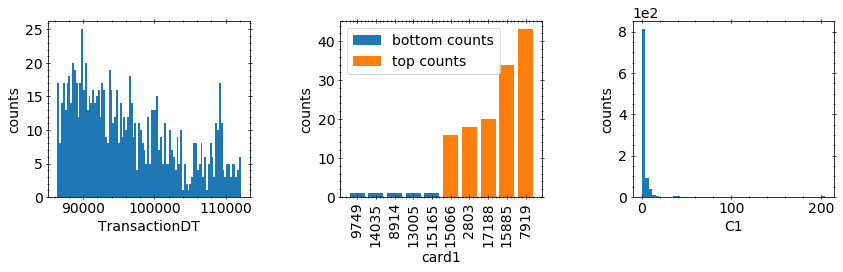

0
1
2


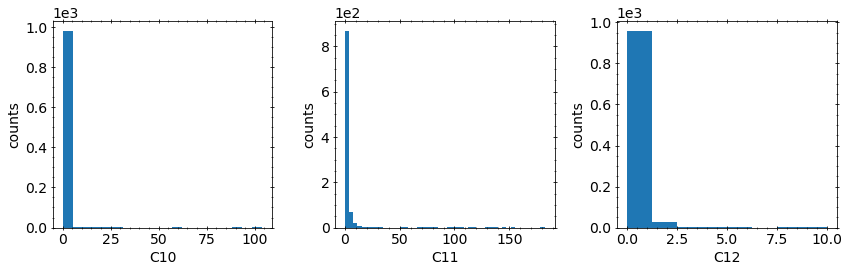

0
1
2


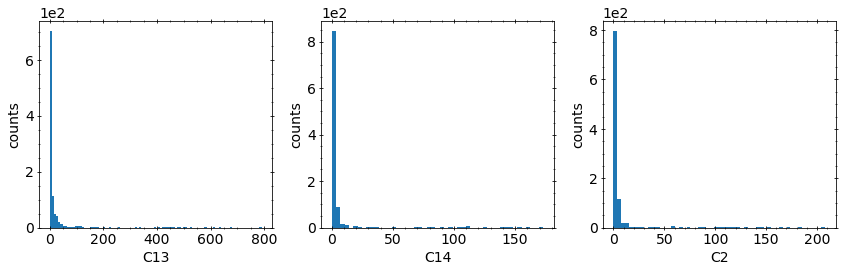

0
1
2


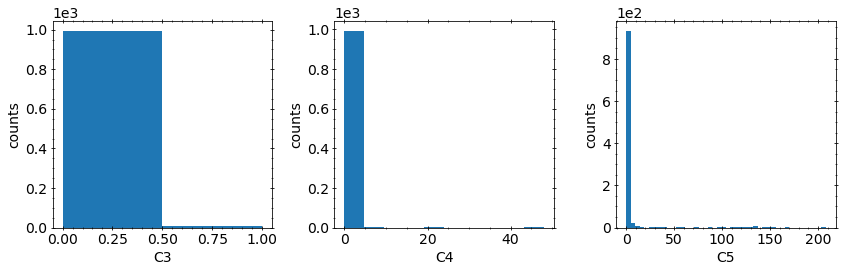

0
1
2


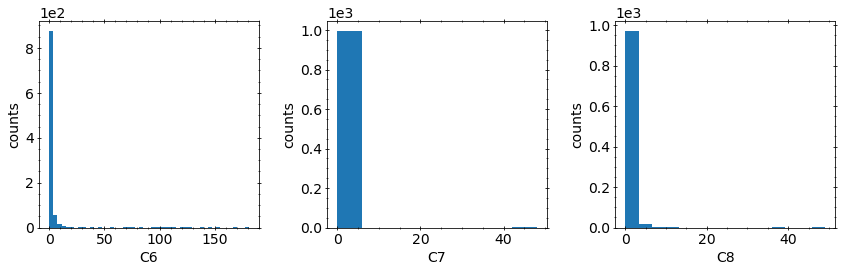

0
1
2


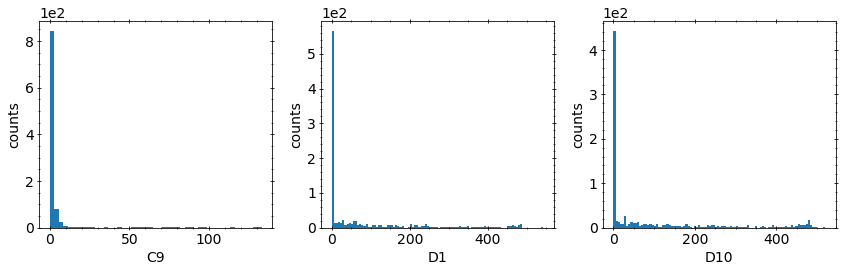

0
1
2


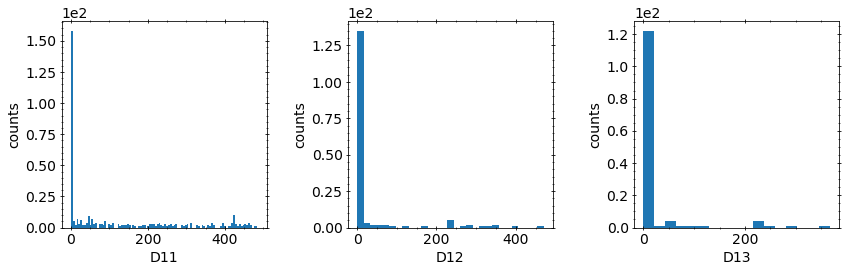

0
1
2


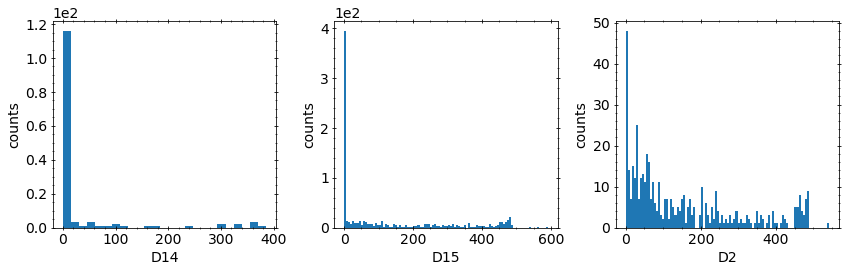

0
1
2


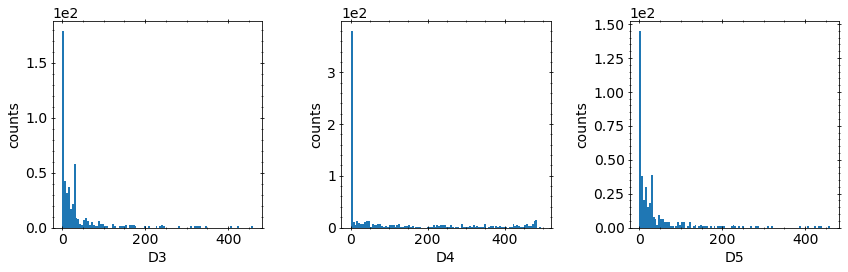

0
1
2


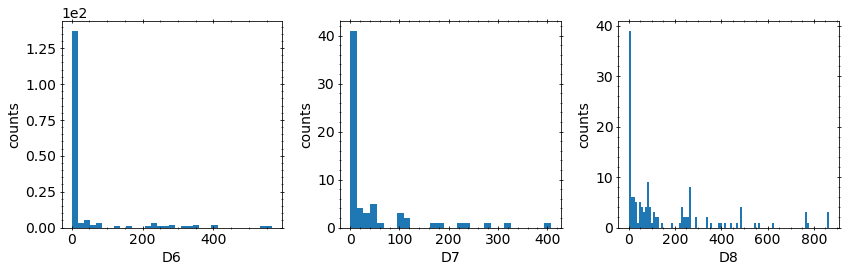

0
1
2


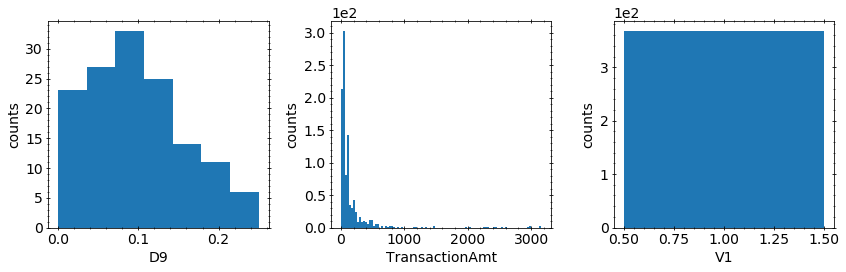

0
1
2


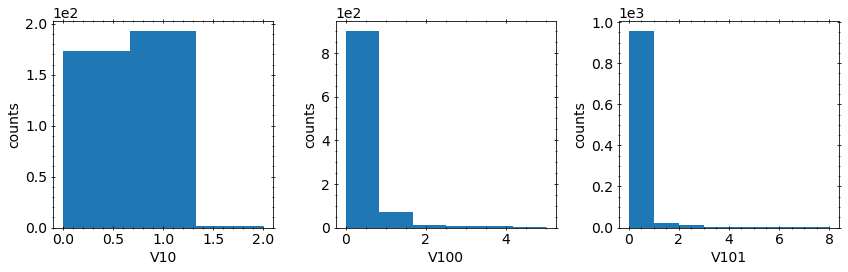

0
1
2


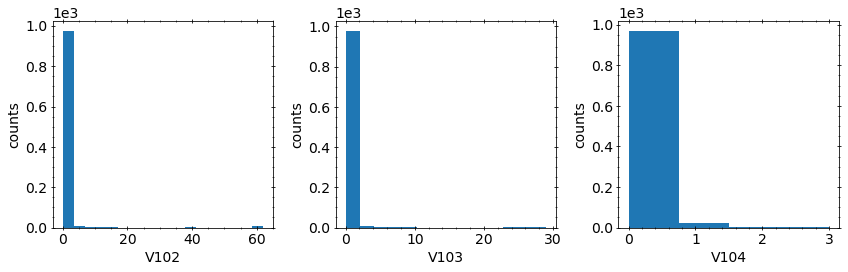

0
1
2


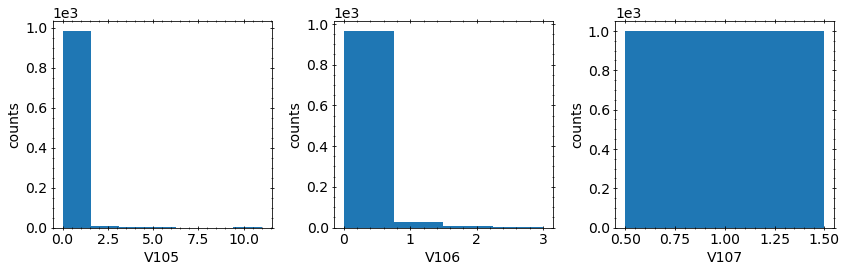

0
1
2


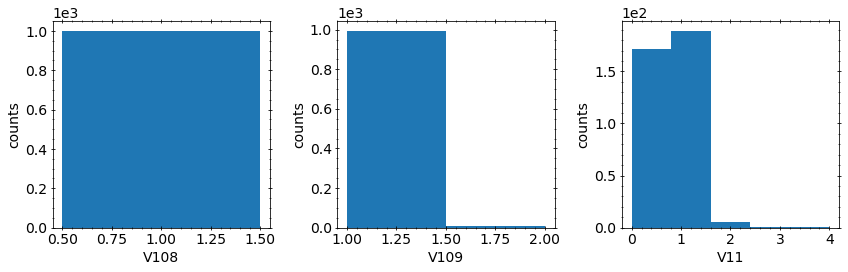

0
1
2


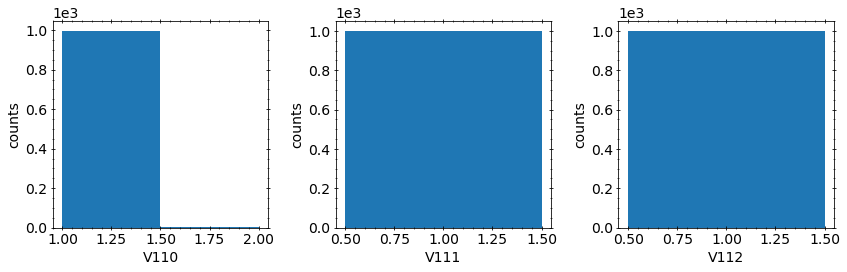

0
1
2


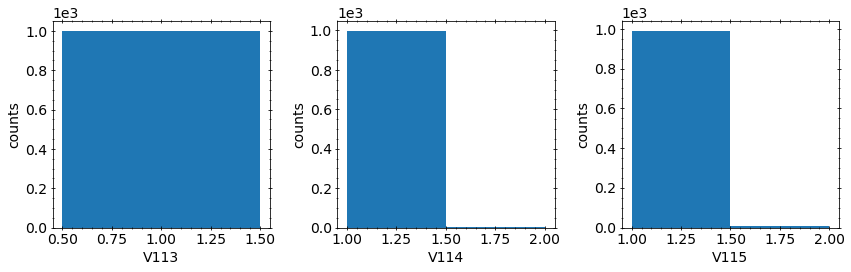

0
1
2


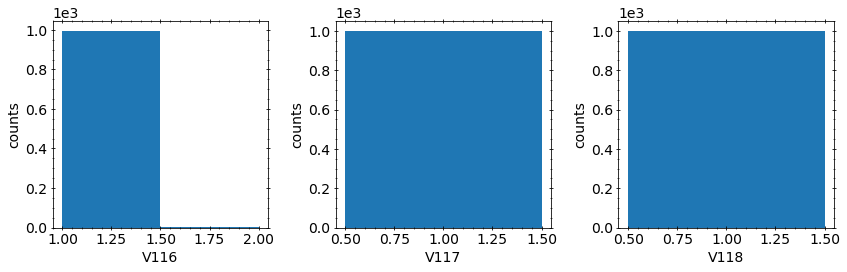

0
1
2


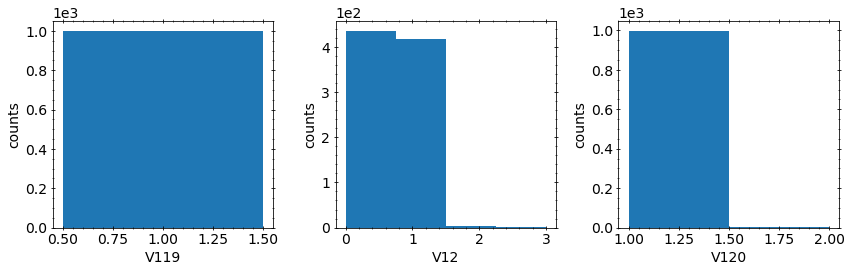

0
1
2


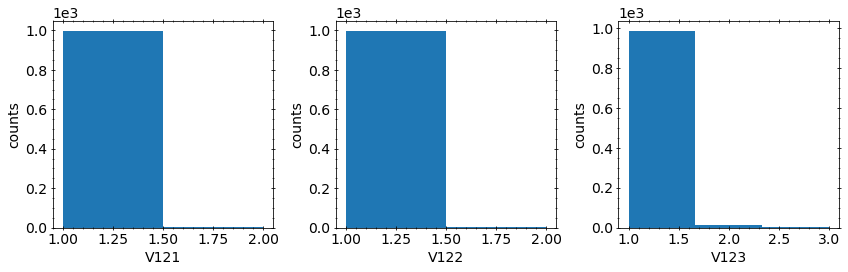

0
1
2


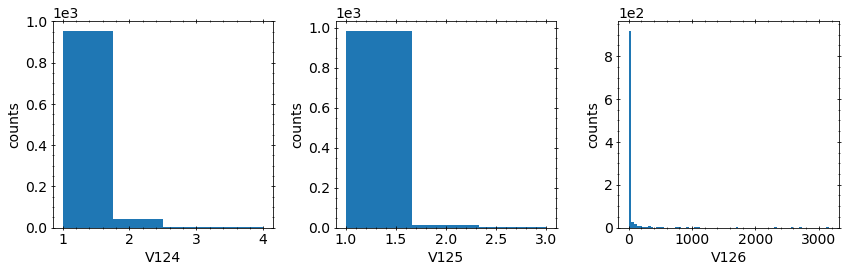

0
1
2


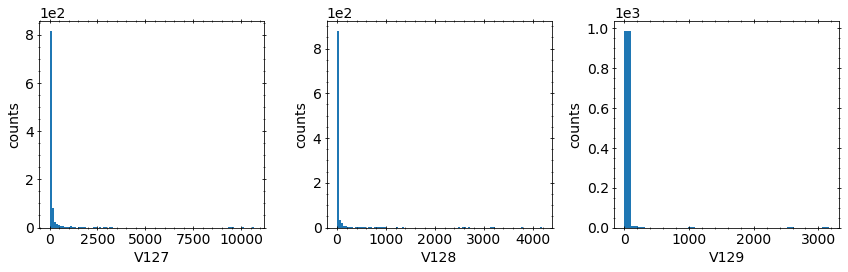

0
1
2


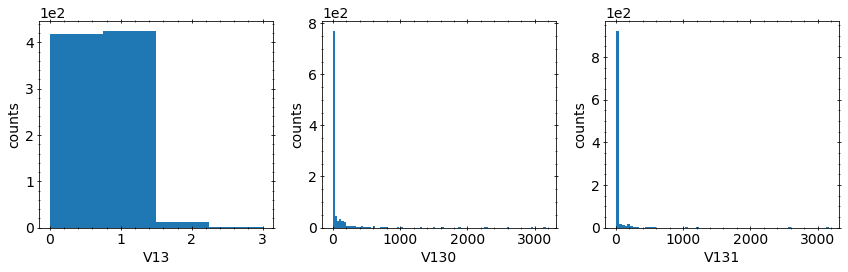

0
1
2


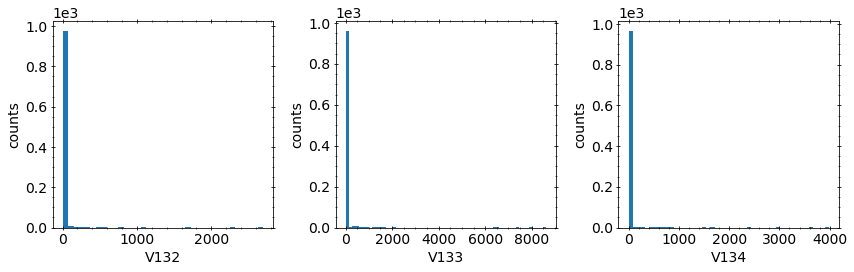

0
1
2


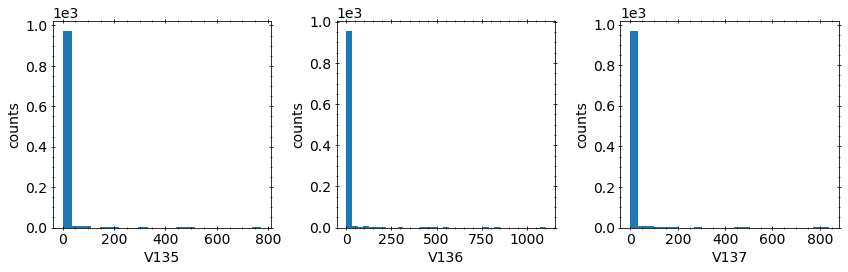

0
1
2


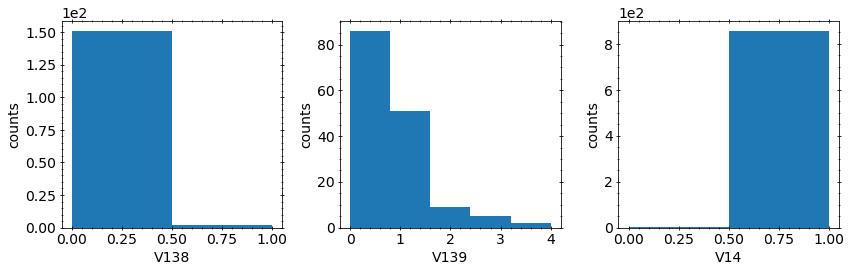

0
1
2


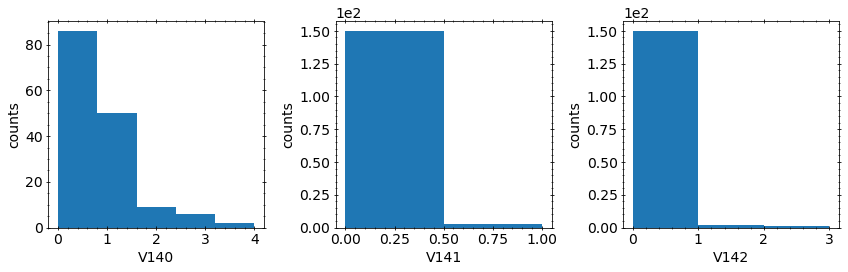

0
1
2


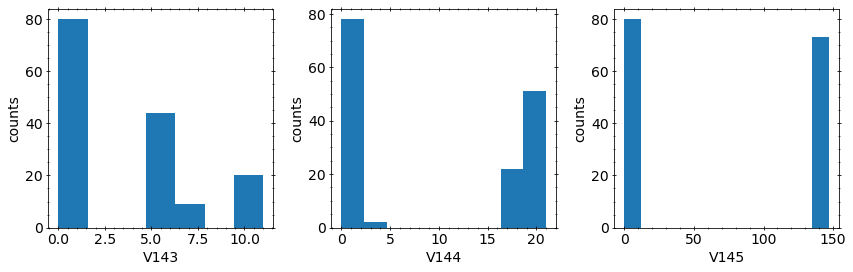

0
1
2


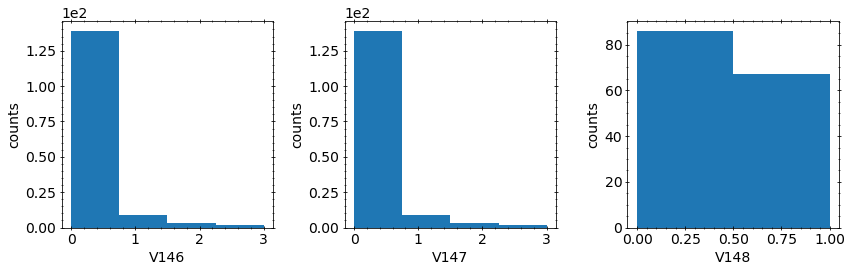

0
1
2


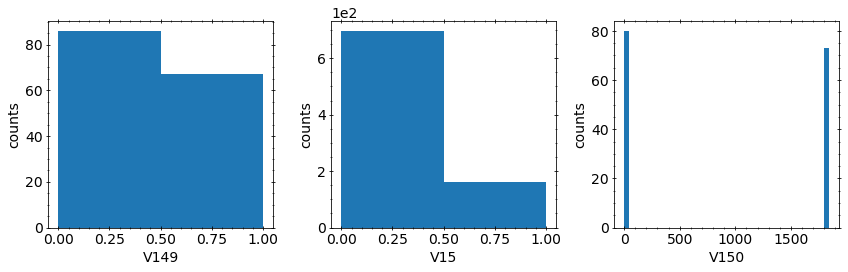

0
1
2


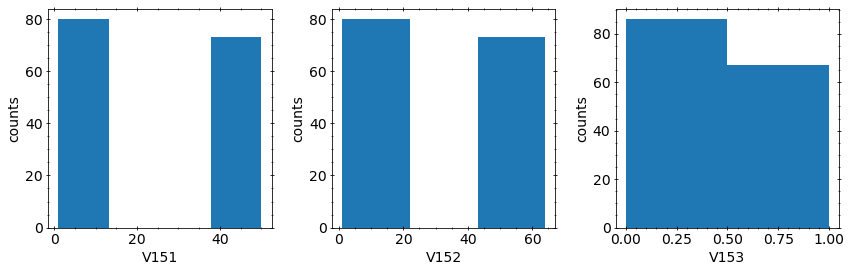

0
1
2


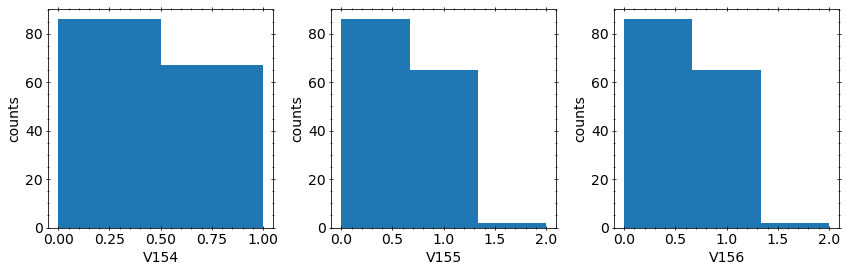

0
1
2


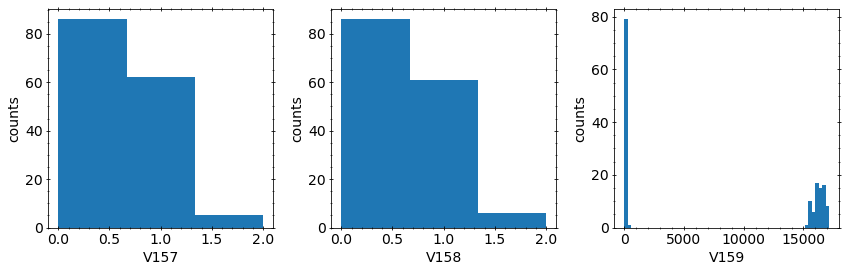

0
1
2


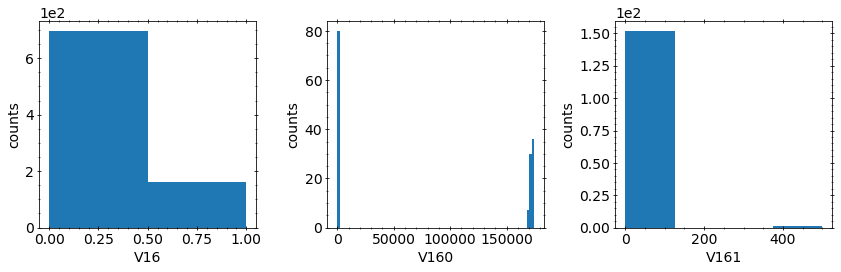

0
1
2


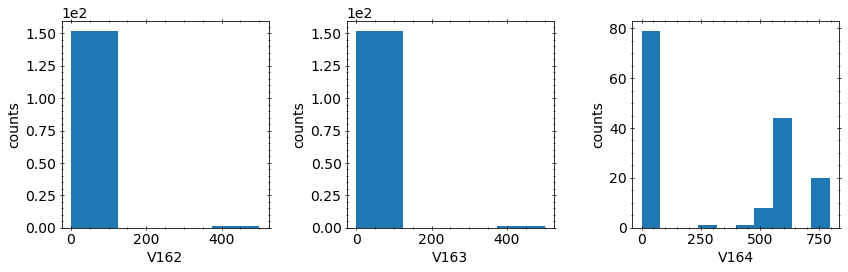

0
1
2


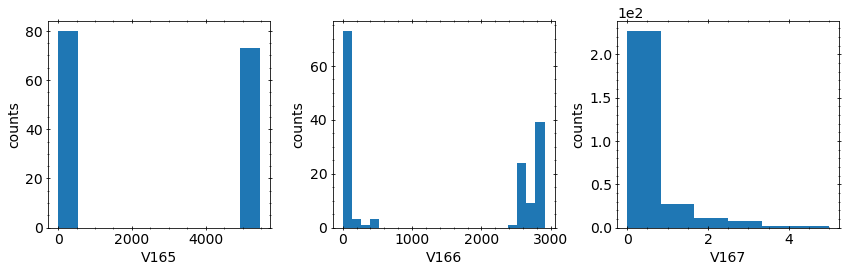

0
1
2


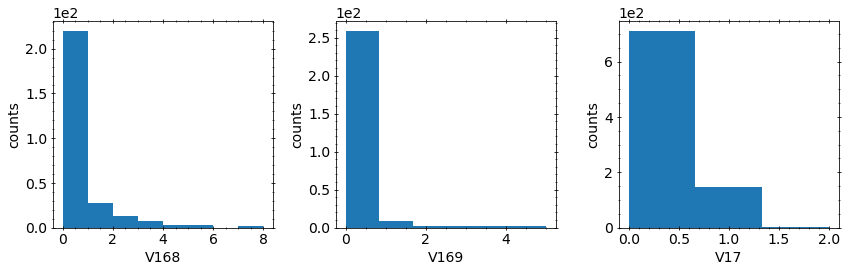

0
1
2


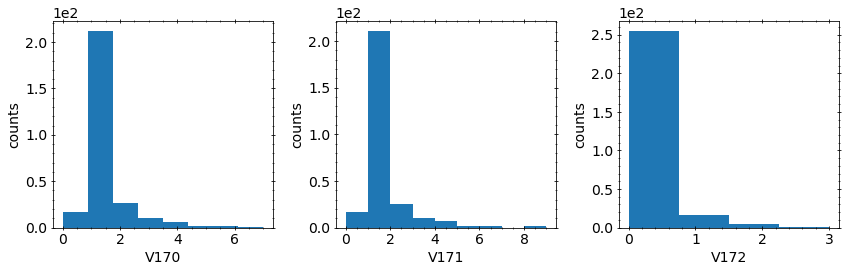

0
1
2


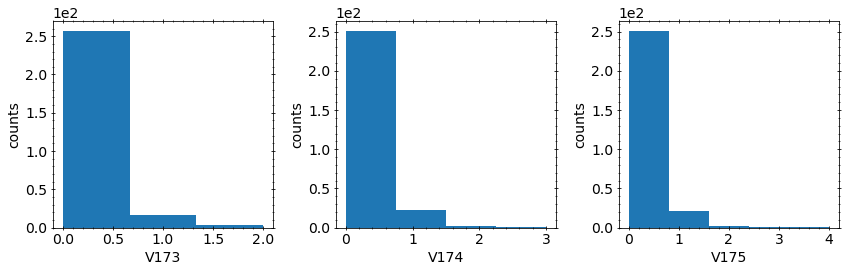

0
1
2


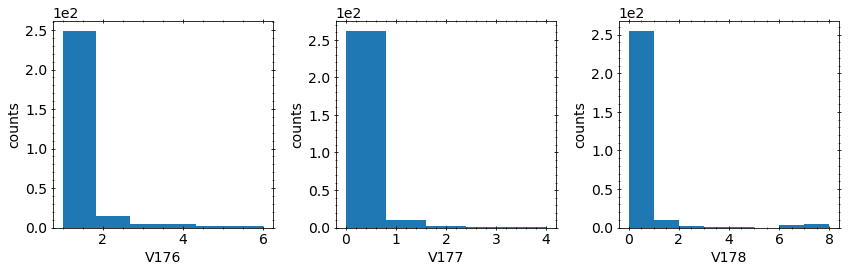

0
1
2


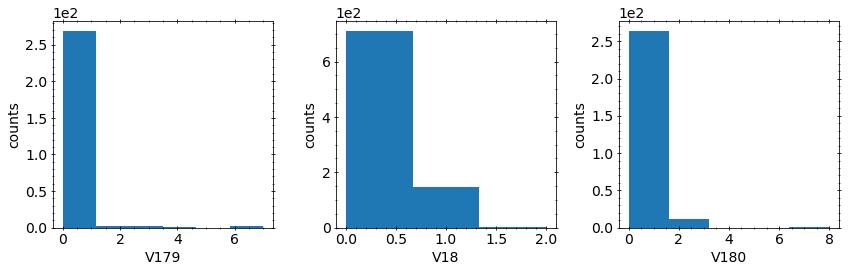

0
1
2


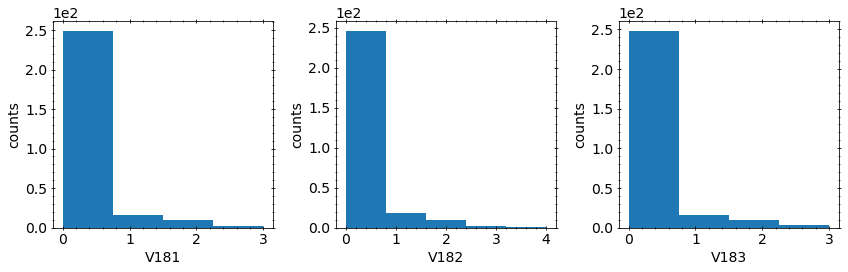

0
1
2


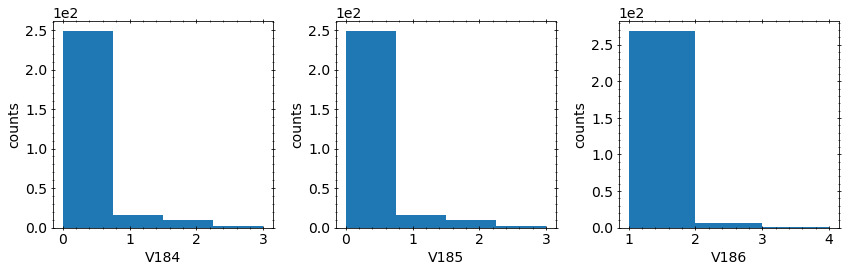

0
1
2


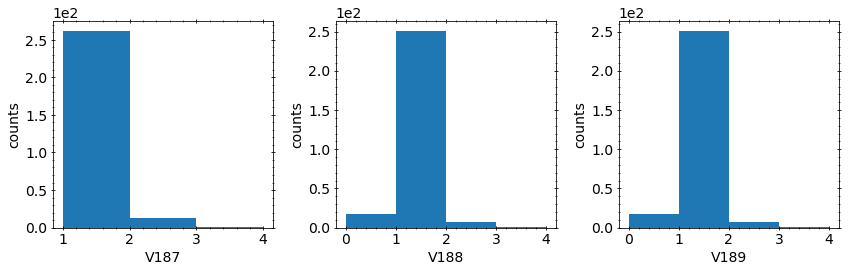

0
1
2


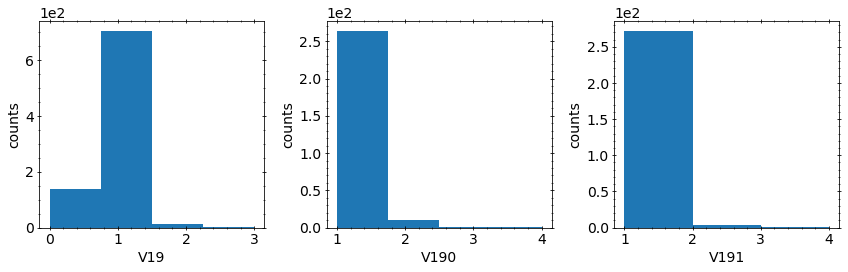

0
1
2


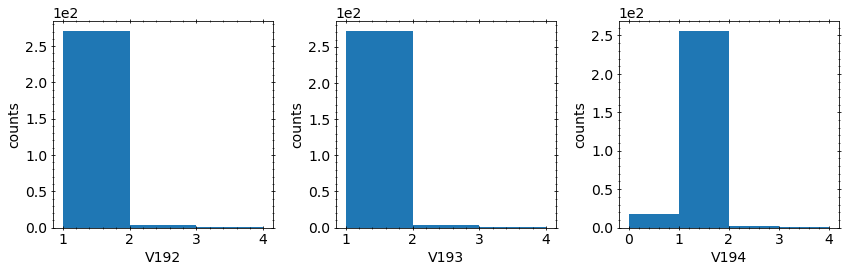

0
1
2


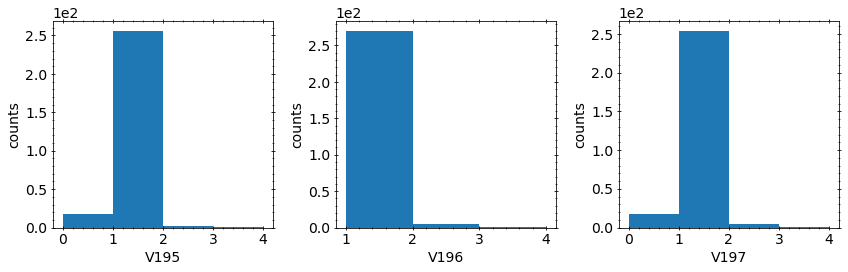

0
1
2


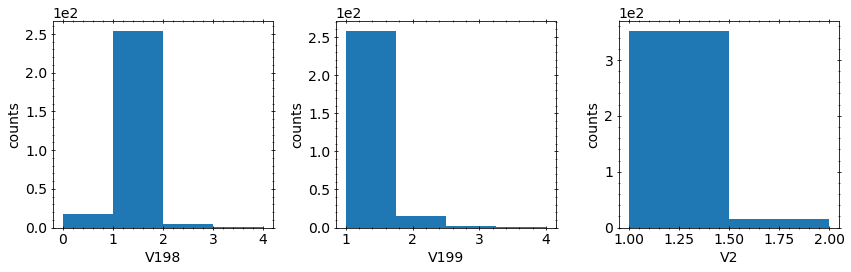

0
1
2


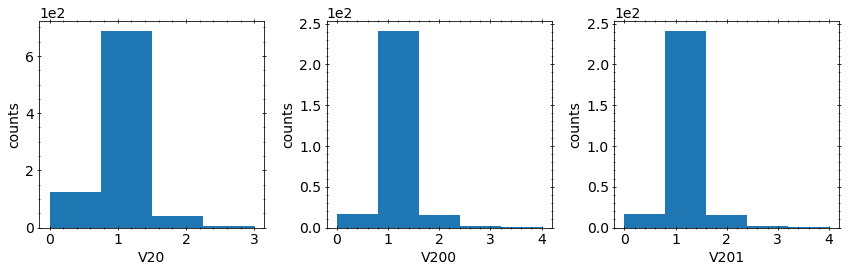

0
1
2


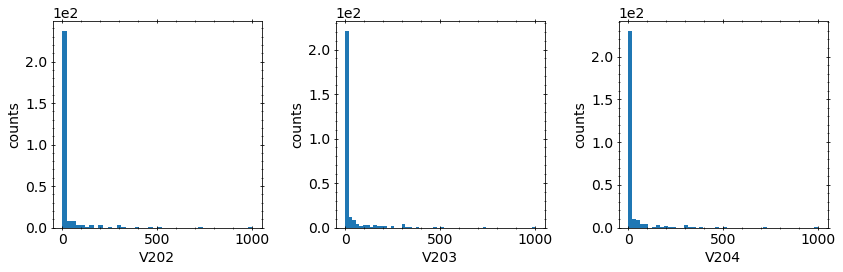

0
1
2


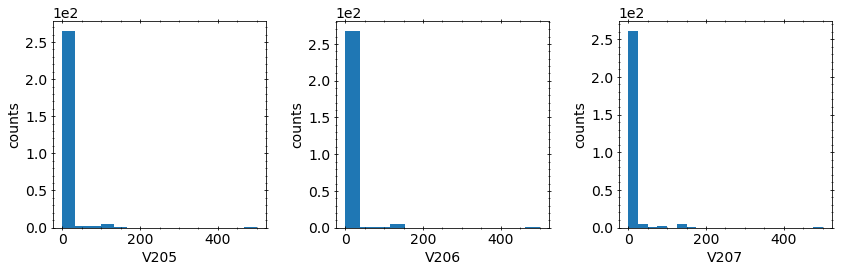

0
1
2


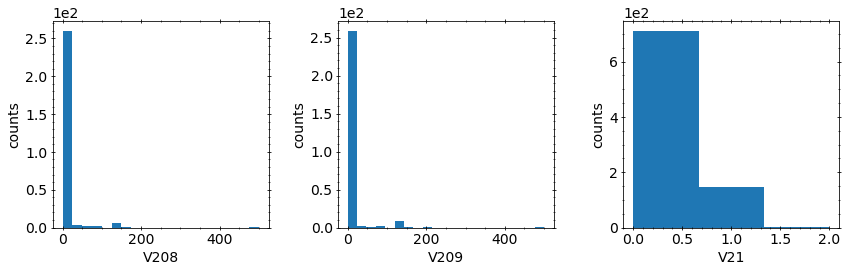

0
1
2


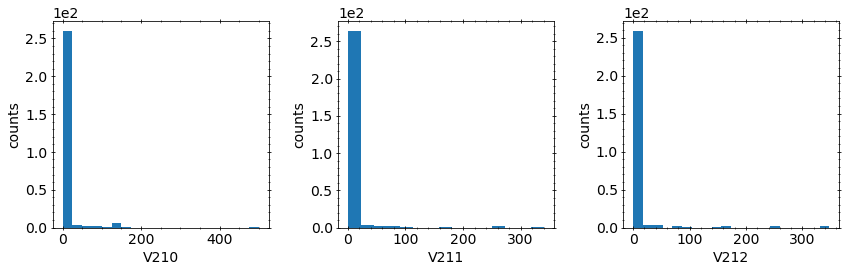

0
1
2


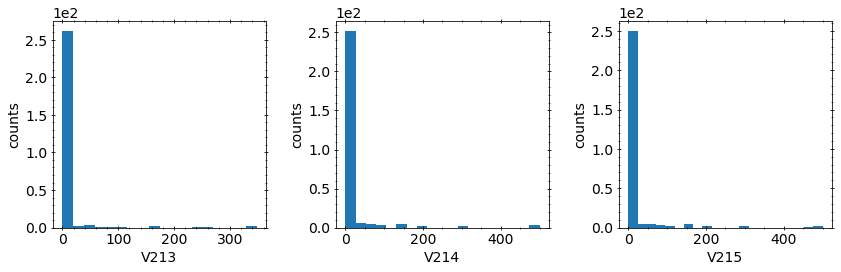

0
1
2


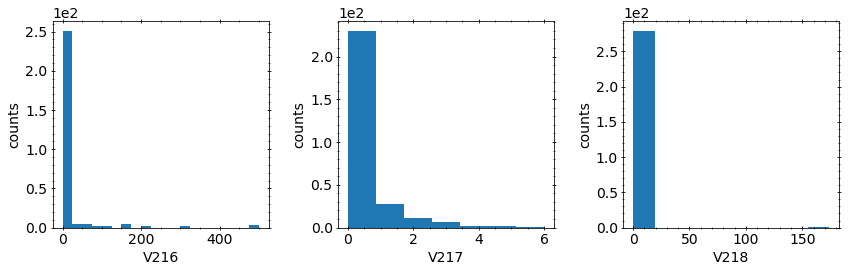

0
1
2


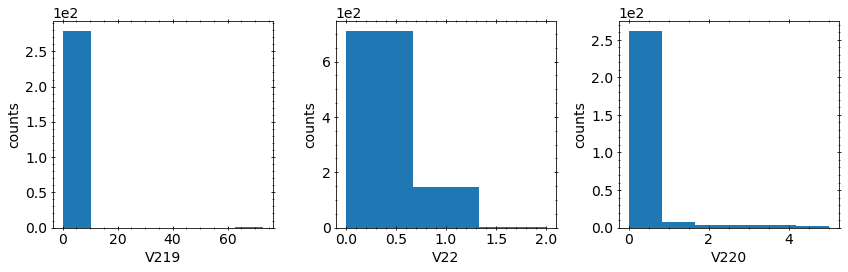

0
1
2


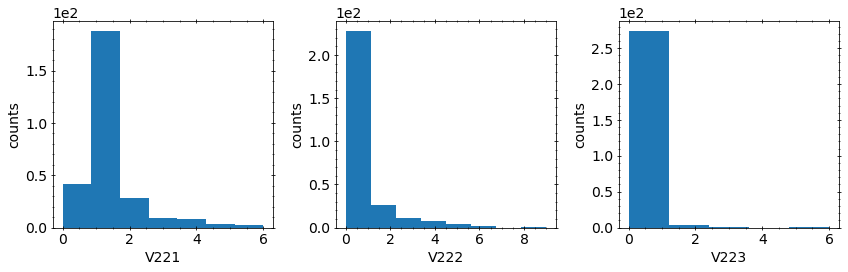

0
1
2


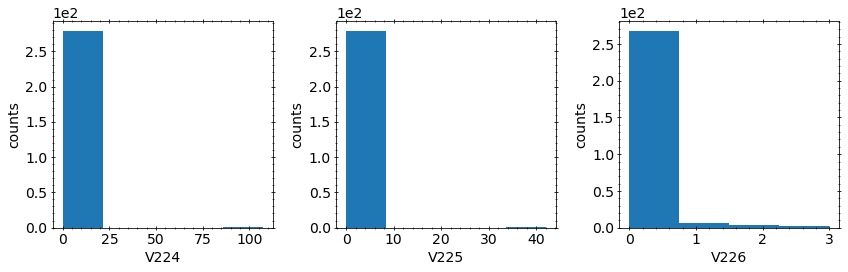

0
1
2


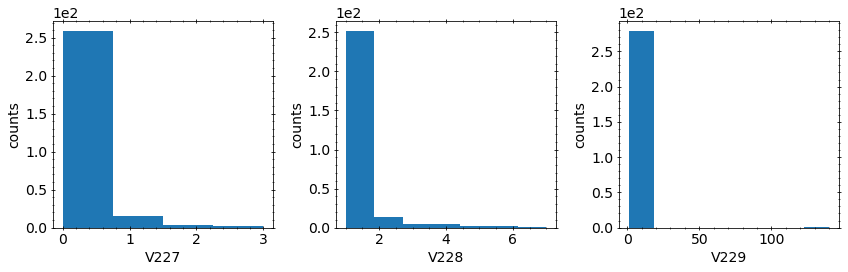

0
1
2


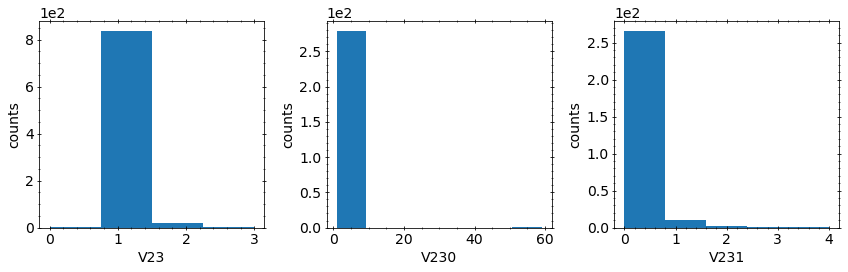

0
1
2


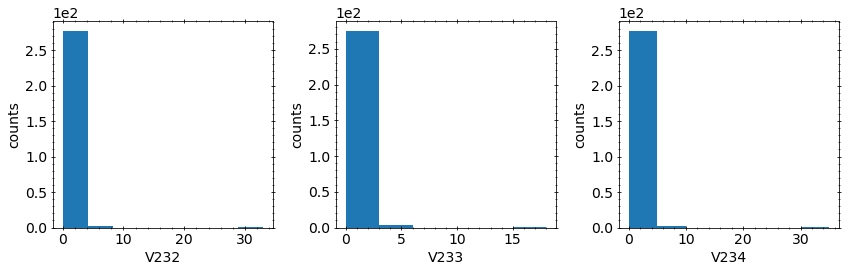

0
1
2


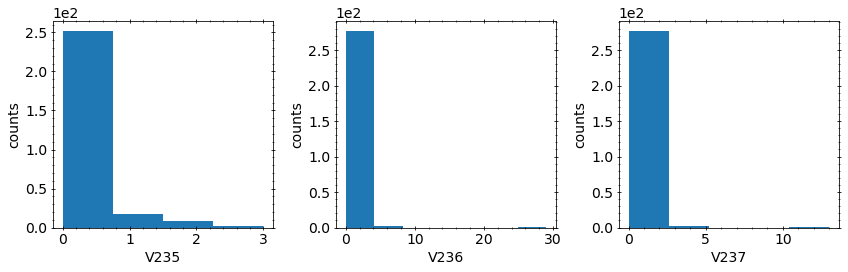

0
1
2


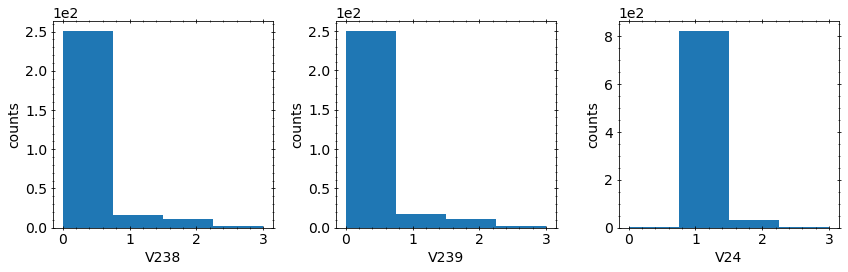

0
1
2


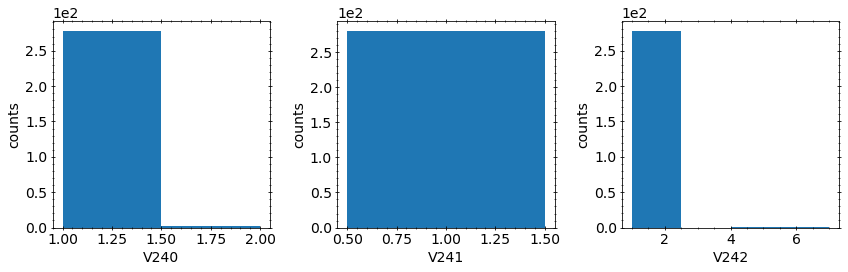

0
1
2


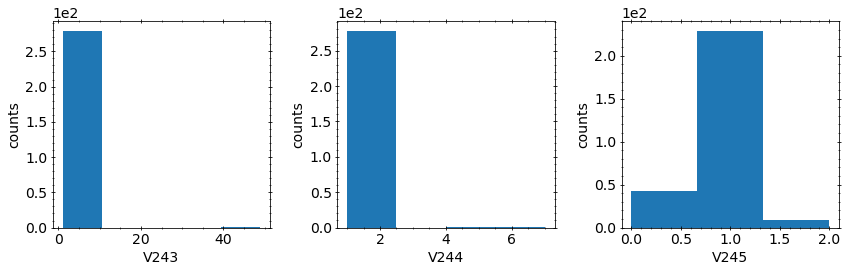

0
1
2


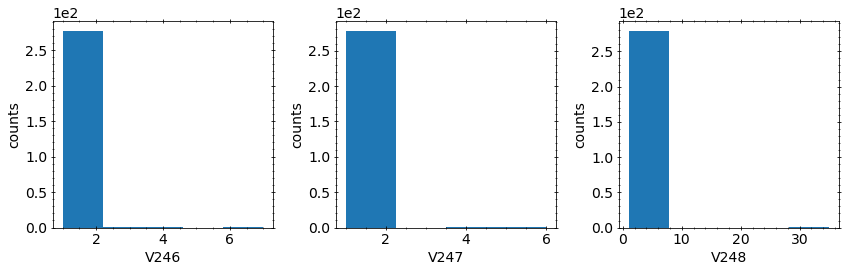

0
1
2


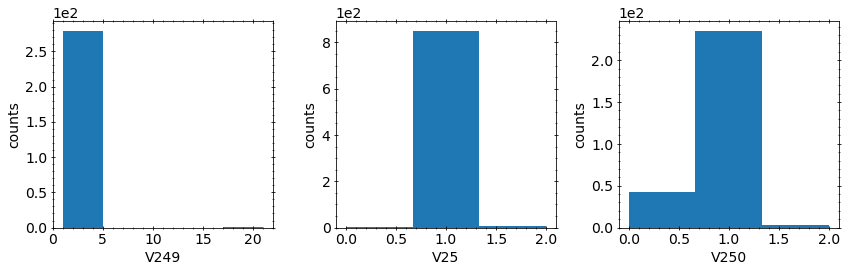

0
1
2


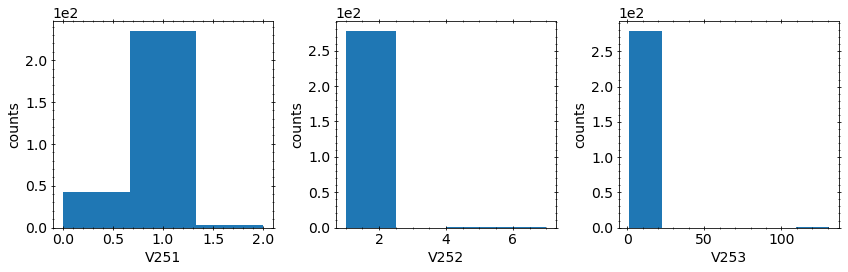

0
1
2


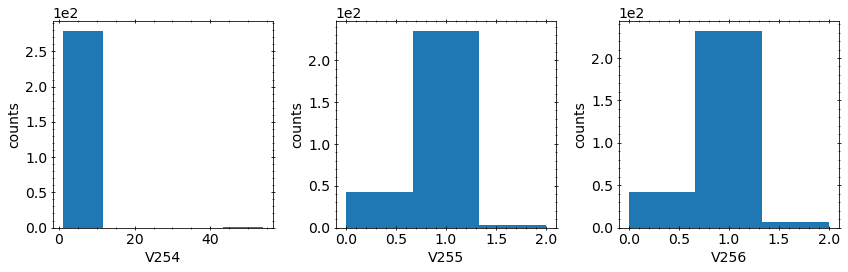

0
1
2


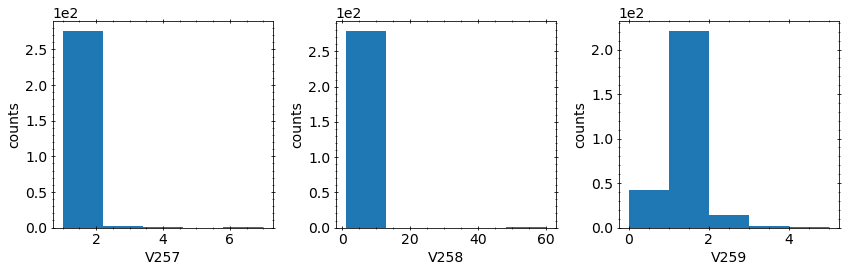

0
1
2


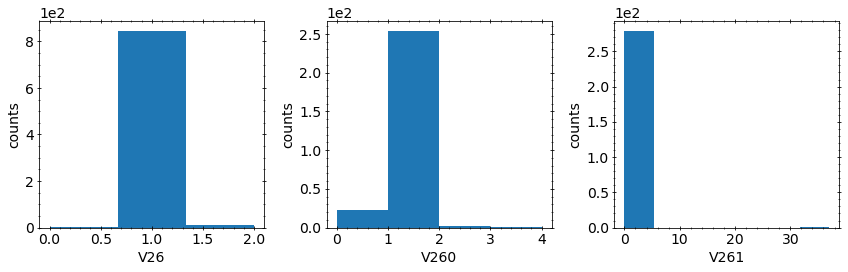

0
1
2


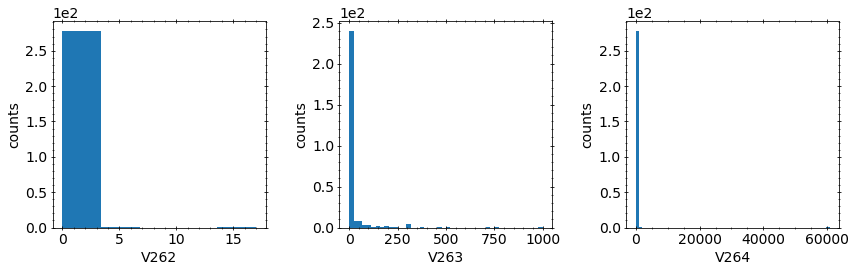

0
1
2


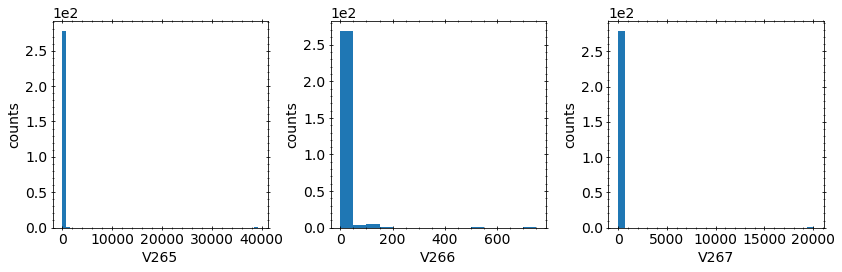

0
1
2


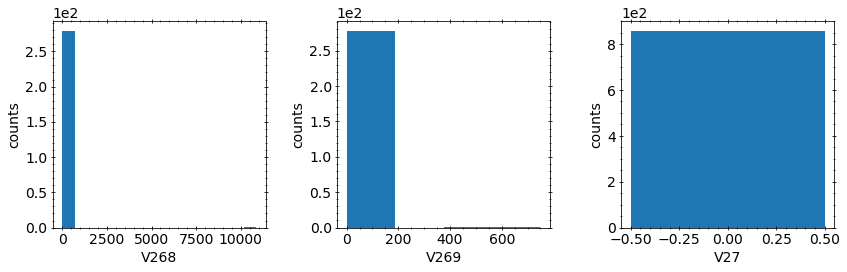

0
1
2


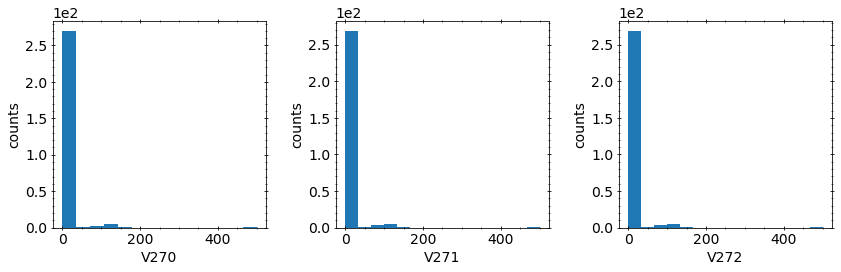

0
1
2


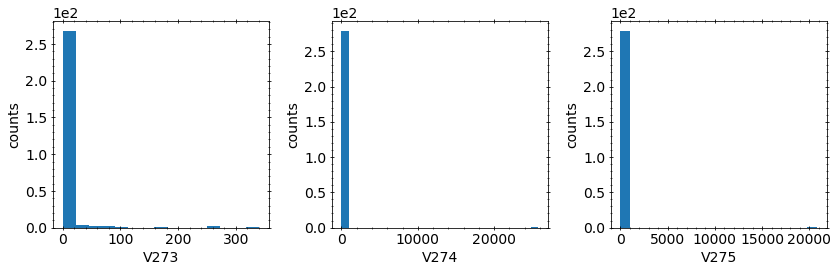

0
1
2


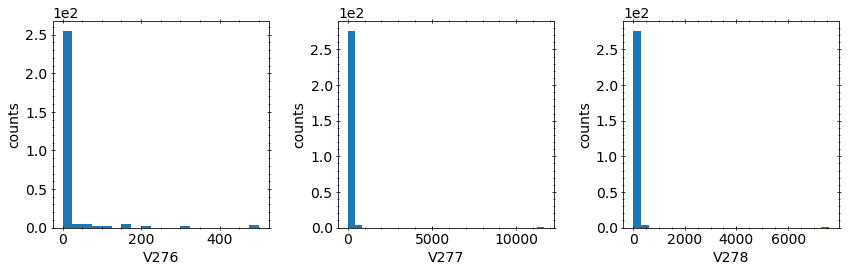

0
1
2


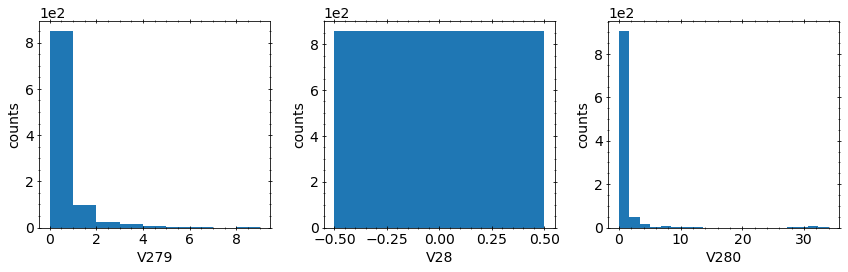

0
1
2


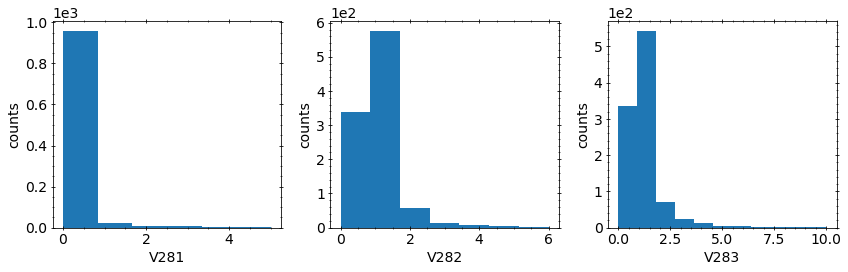

0
1
2


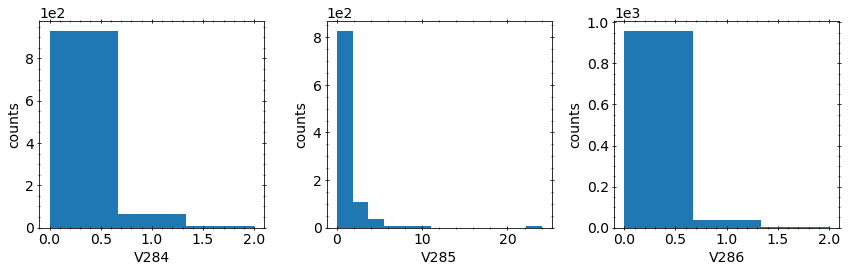

0
1
2


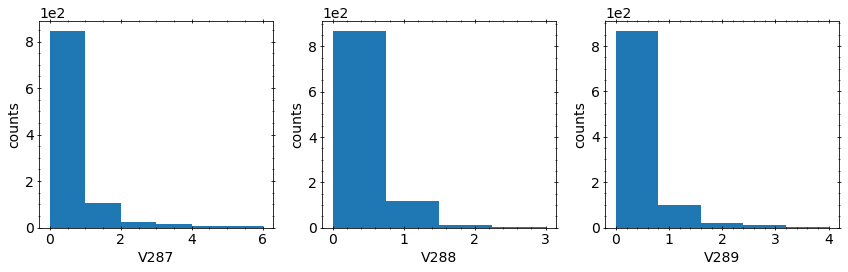

0
1
2


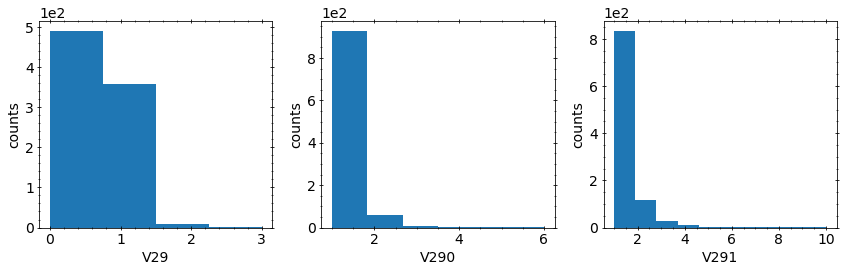

0
1
2


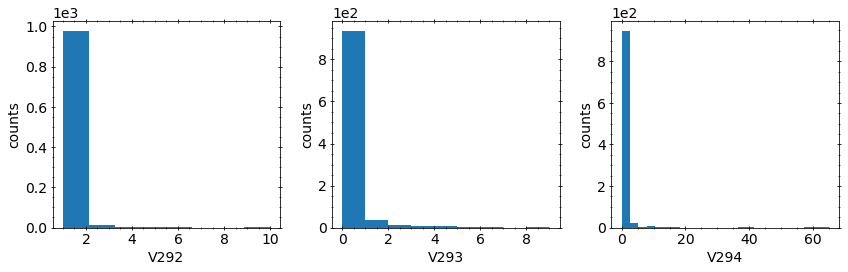

0
1
2


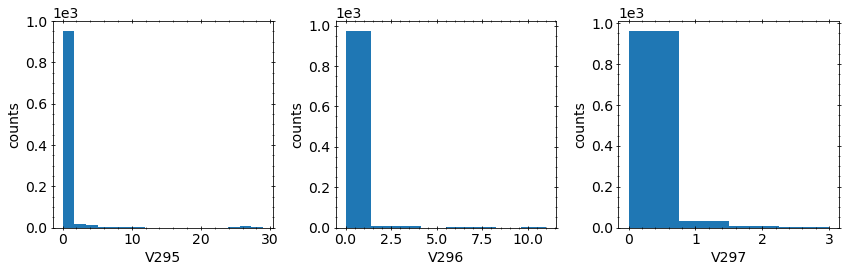

0
1
2


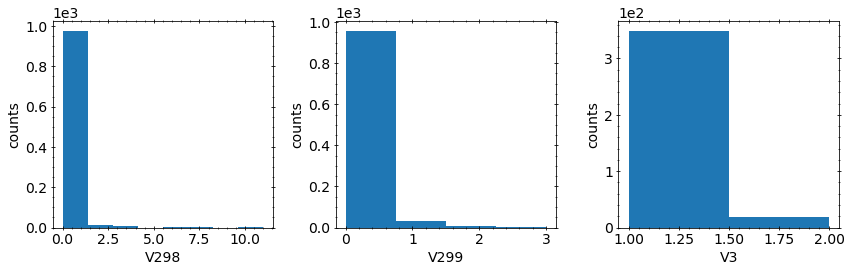

0
1
2


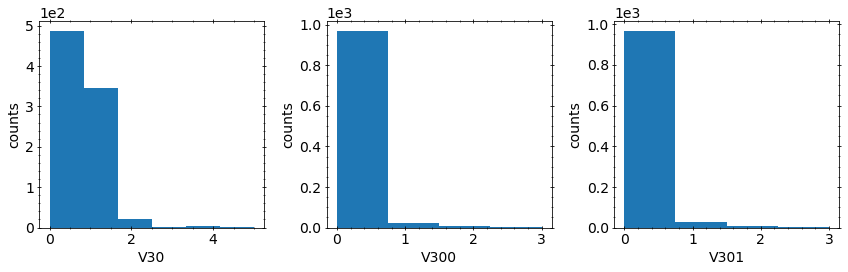

0
1
2


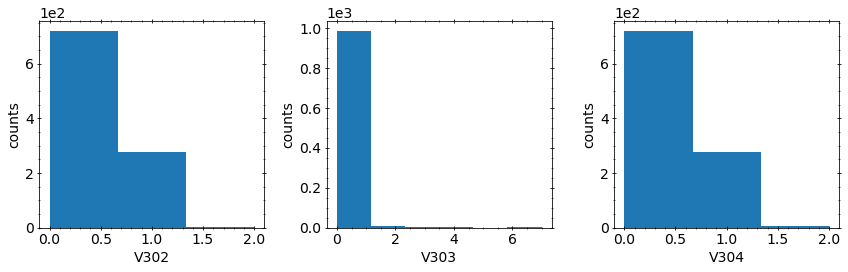

0
1
2


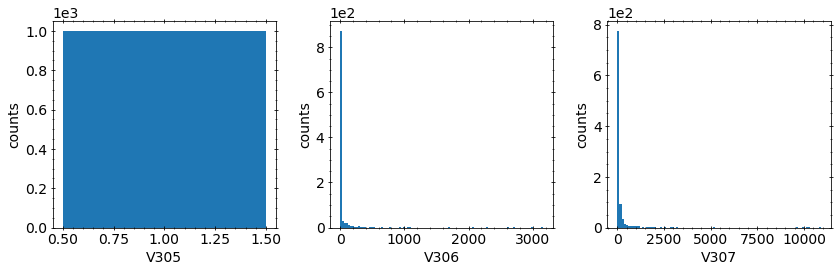

0
1
2


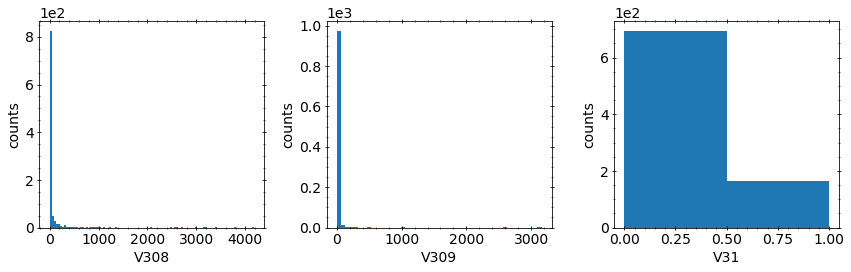

0
1
2


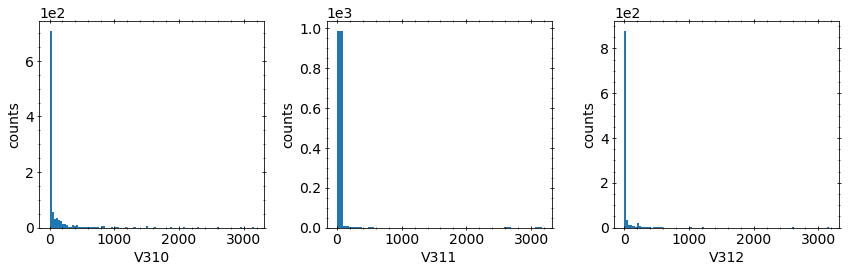

0
1
2


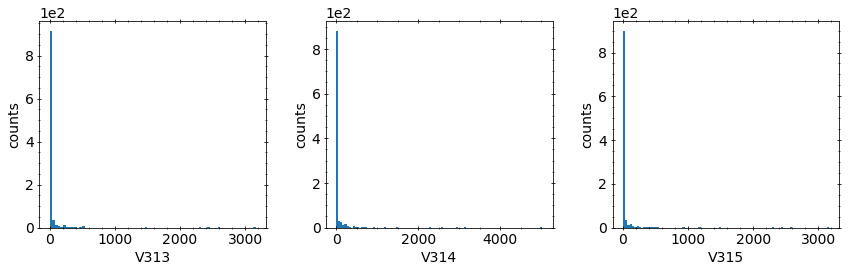

0
1
2


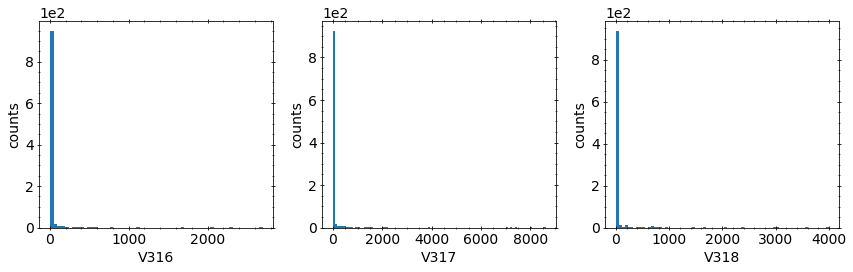

0
1
2


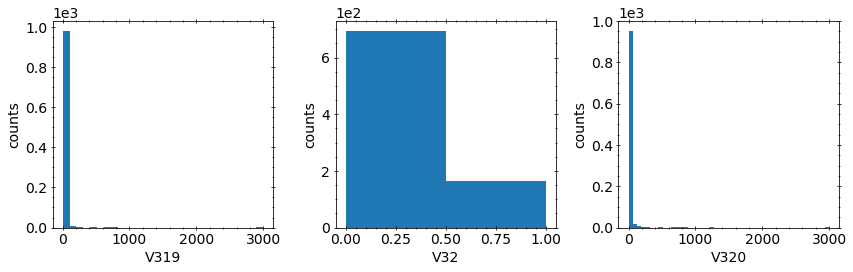

0
1
2


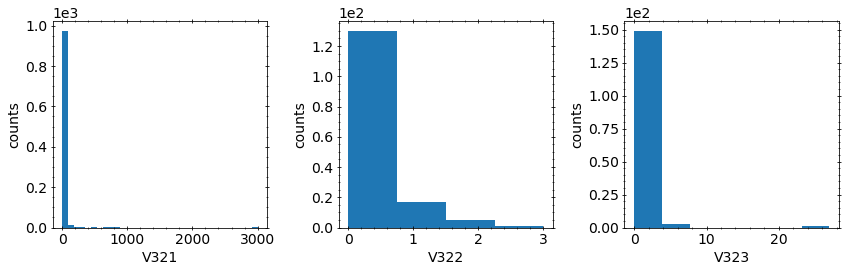

0
1
2


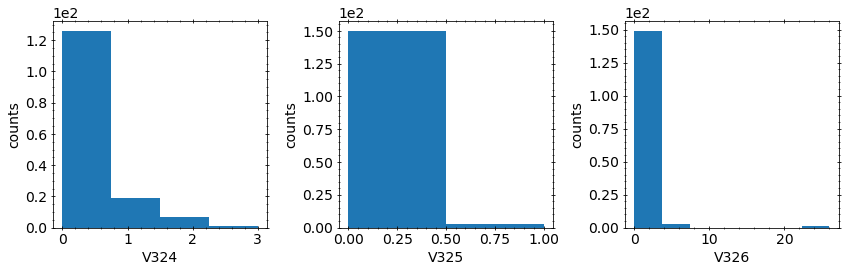

0
1
2


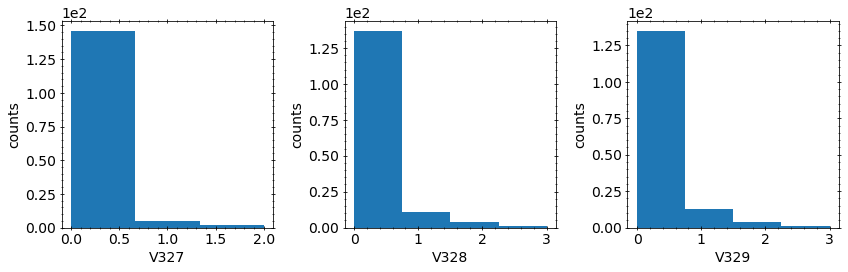

0
1
2


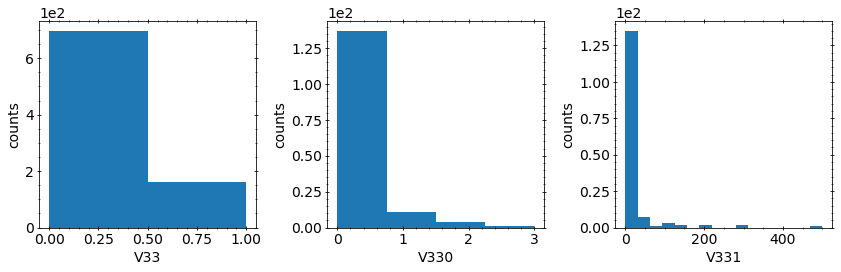

0
1
2


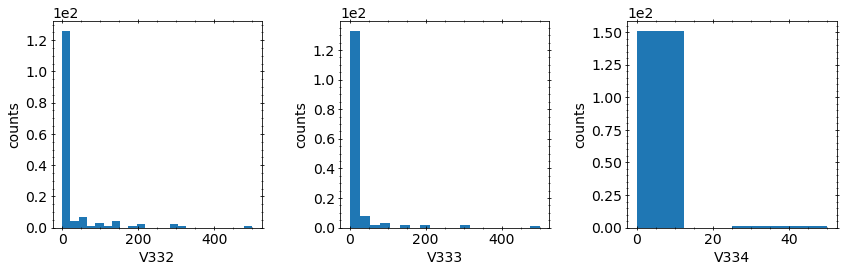

0
1
2


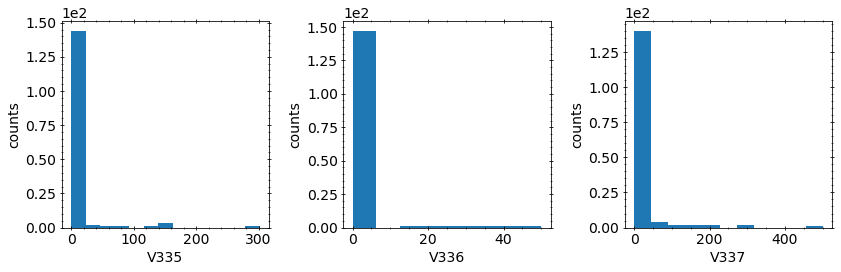

0
1
2


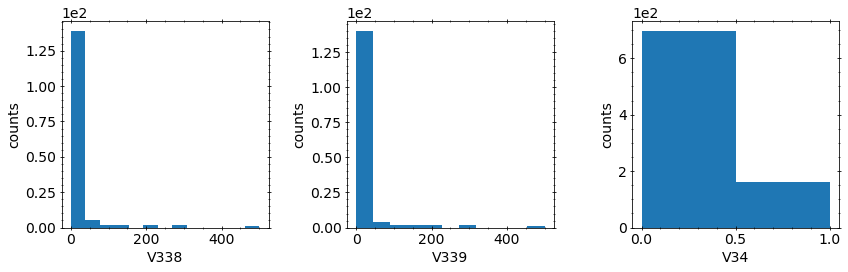

0
1
2


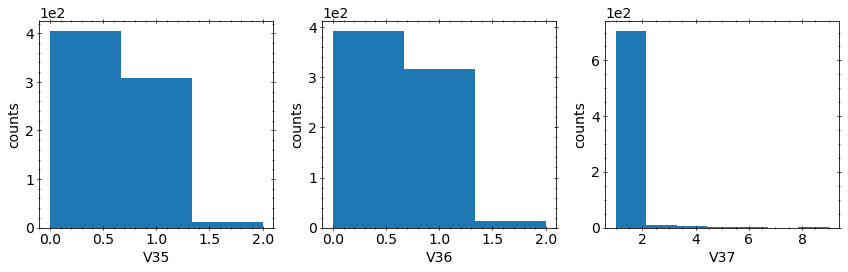

0
1
2


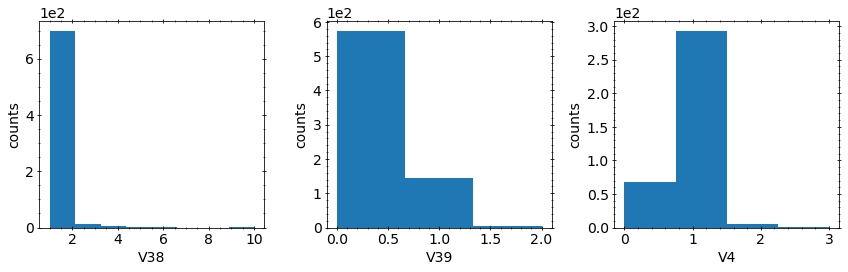

0
1
2


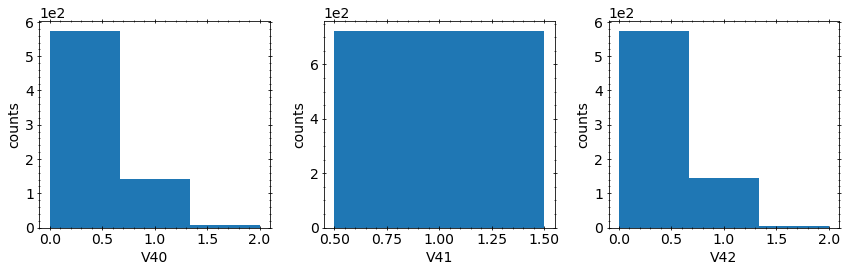

0
1
2


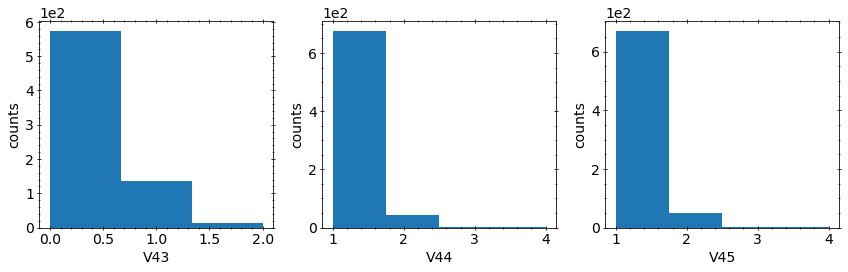

0
1
2


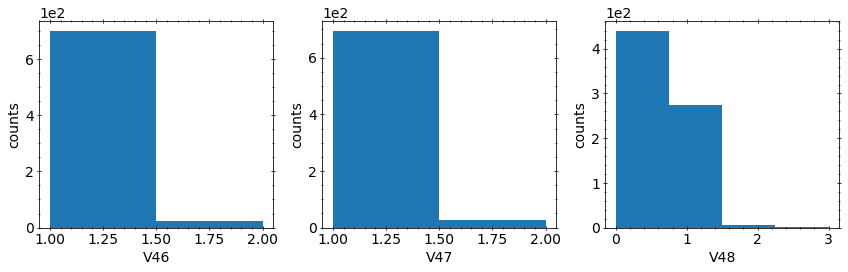

0
1
2


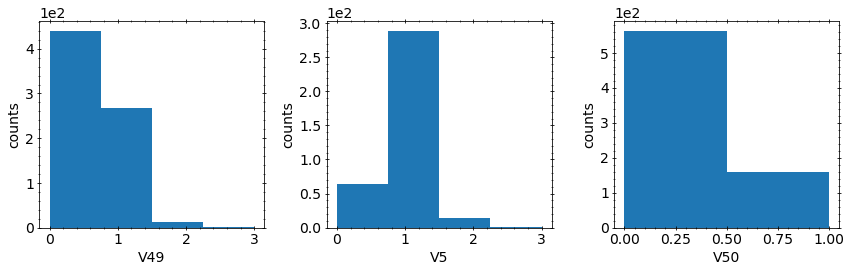

0
1
2


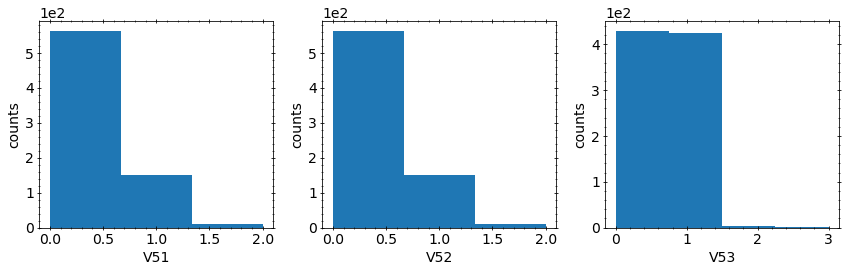

0
1
2


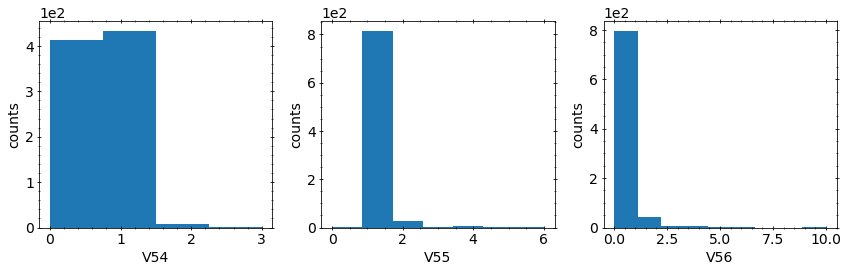

0
1
2


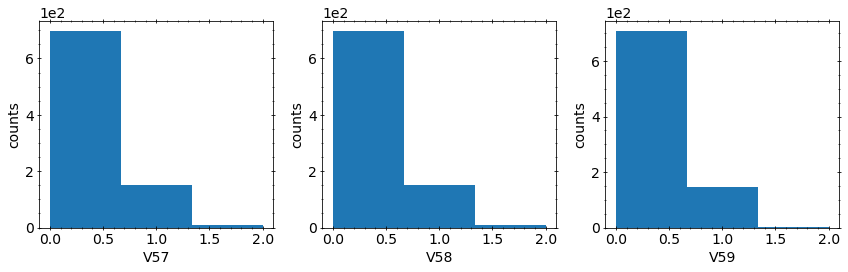

0
1
2


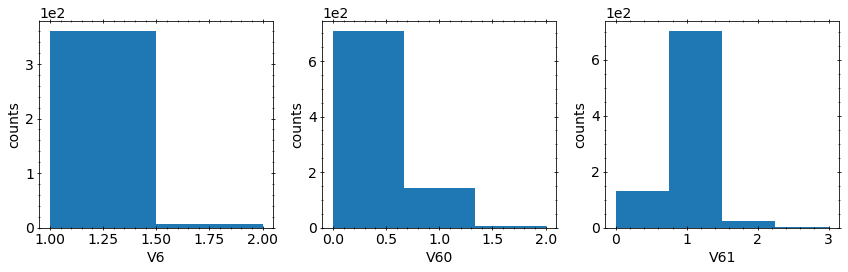

0
1
2


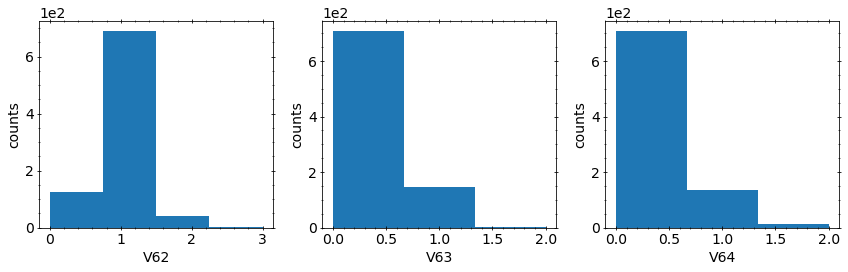

0
1
2


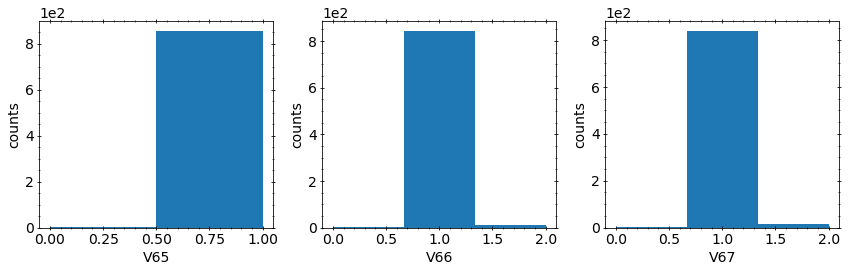

0
1
2


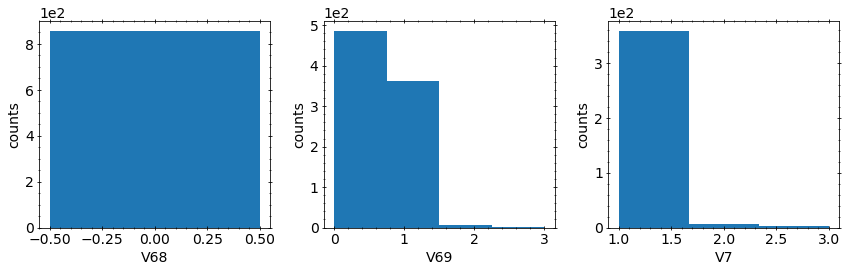

0
1
2


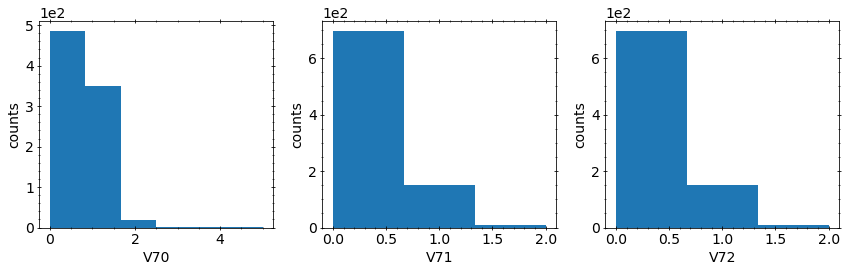

0
1
2


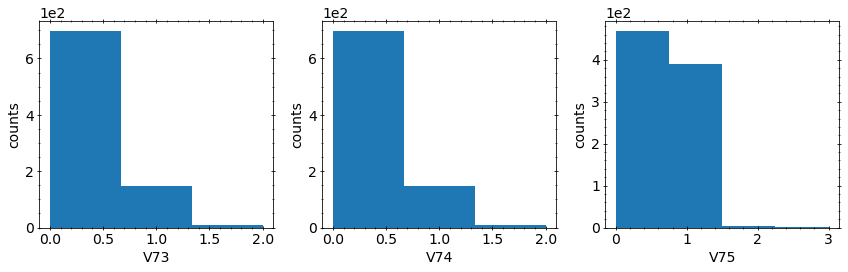

0
1
2


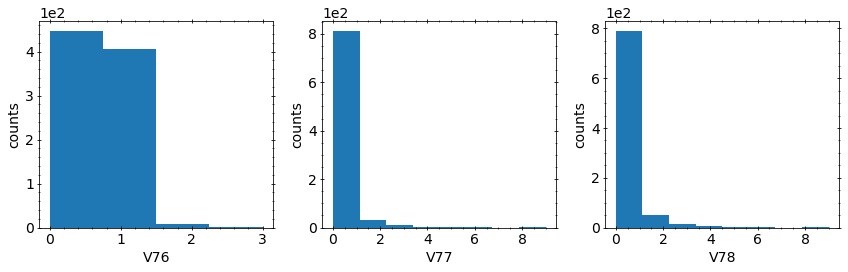

0
1
2


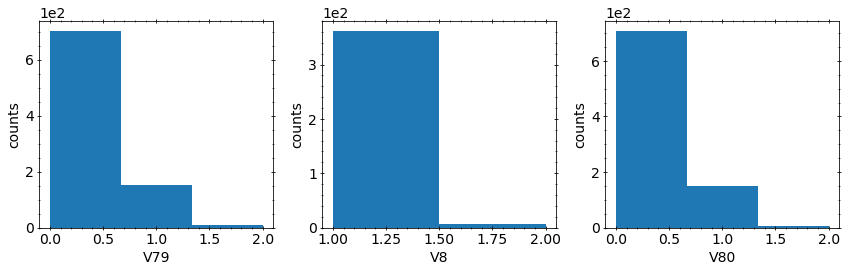

0
1
2


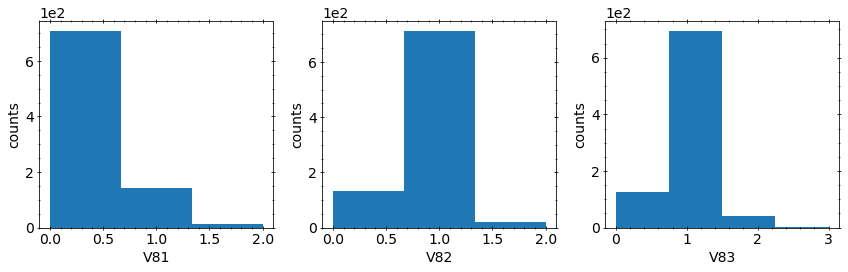

0
1
2


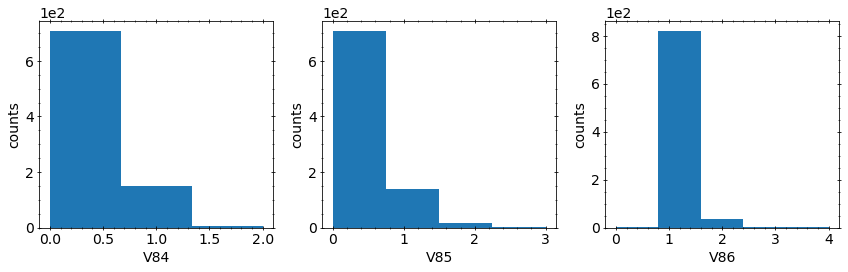

0
1
2


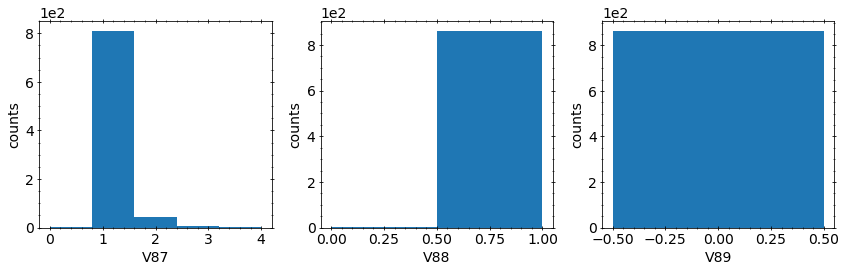

0
1
2


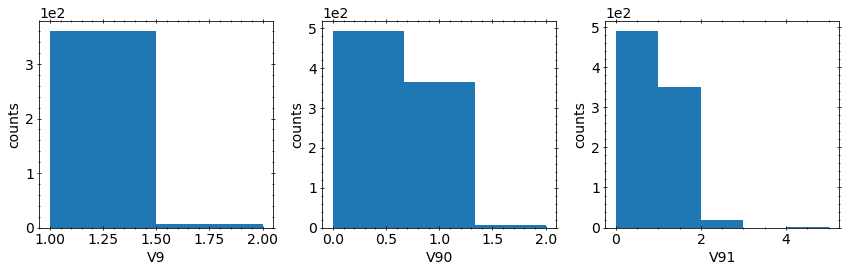

0
1
2


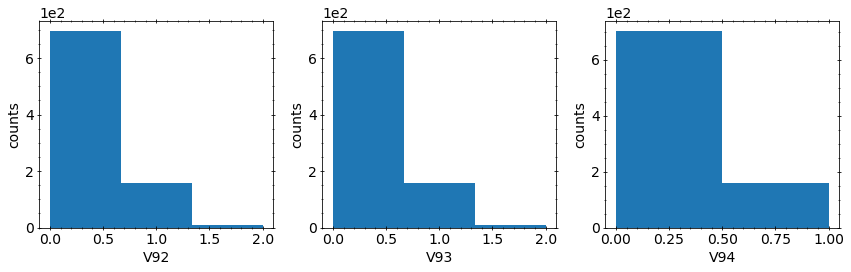

0
1
2


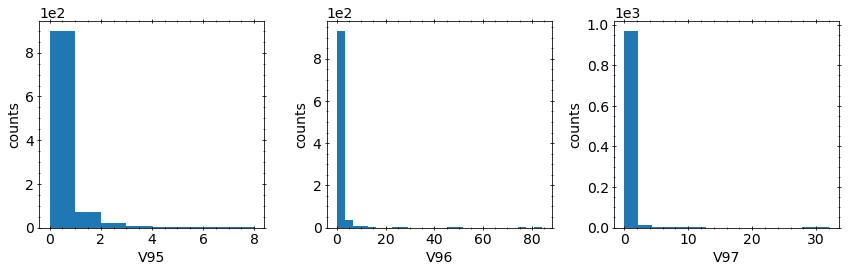

0
1
2


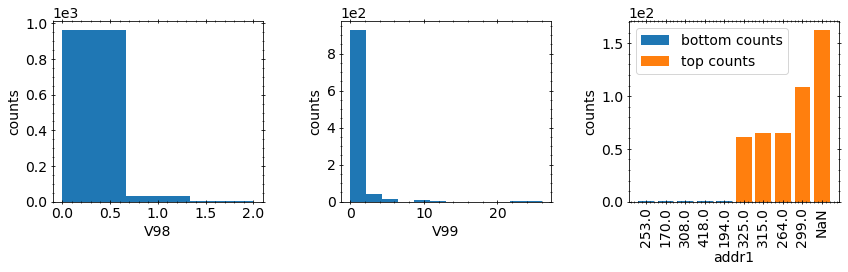

0
1
2


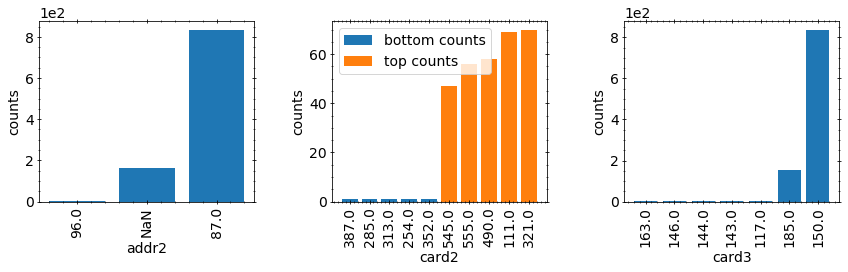

0
1
2


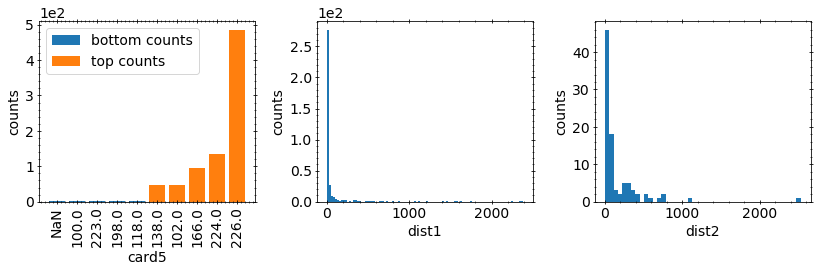

0
1
2


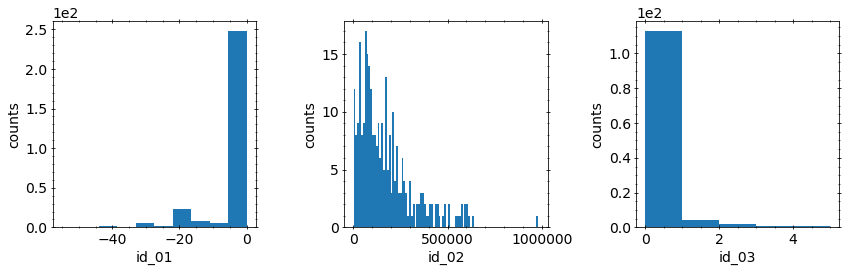

0
1
2


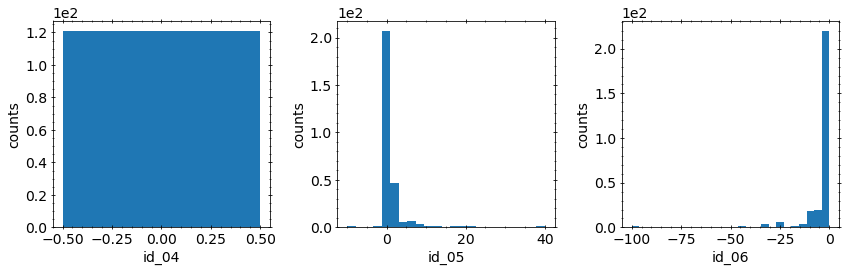

0
1
2


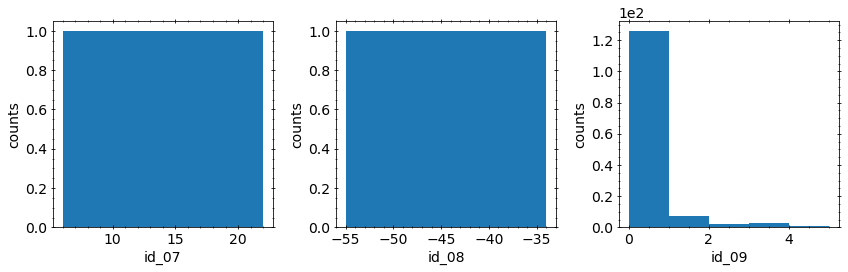

0
1
2


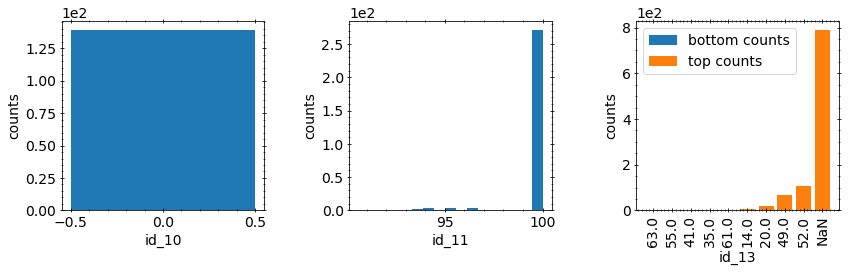

0
1
2


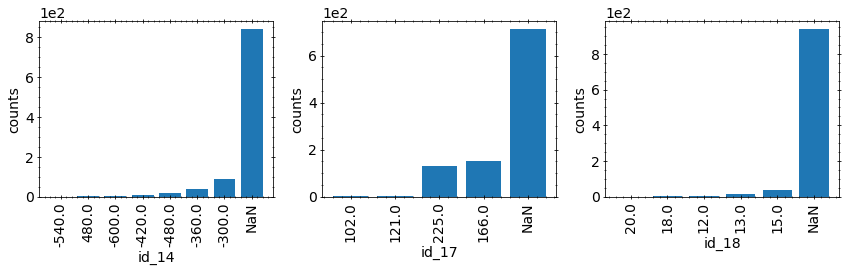

0
1
2


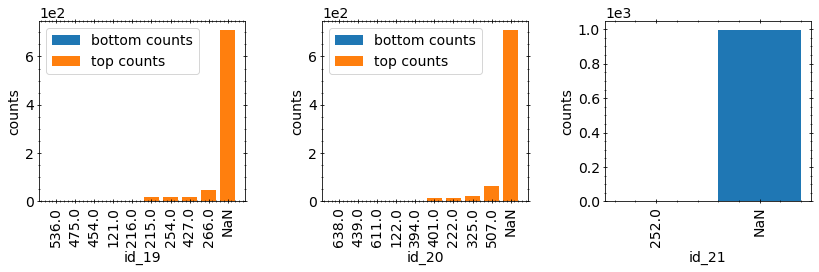

0
1
2


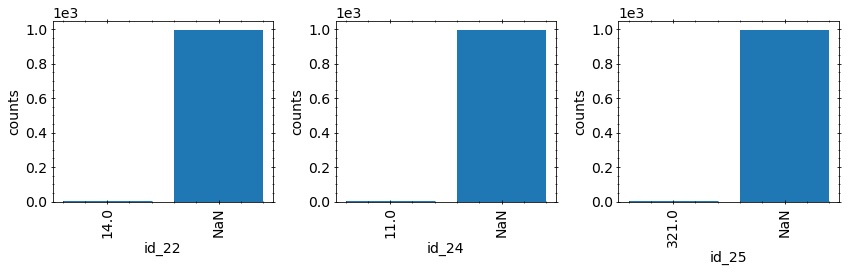

0
1
2


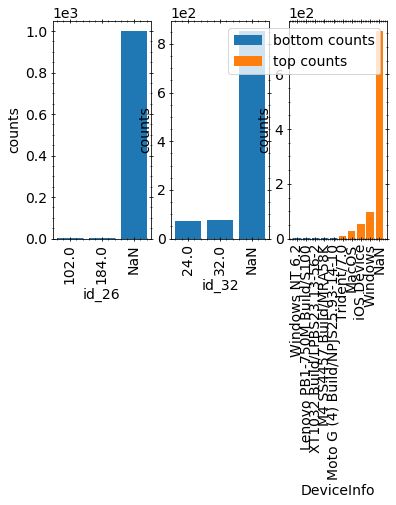

3


IndexError: index 3 is out of bounds for axis 0 with size 3

In [49]:
importlib.reload(JLpyUtils.plot)
JLpyUtils.plot.hist_or_bar(X.head(1000), 
                           categorical_headers= headers_dict['categorical features'])

In [50]:
y.head()

,isFraud
0,0
1,0
2,0
3,0
4,0


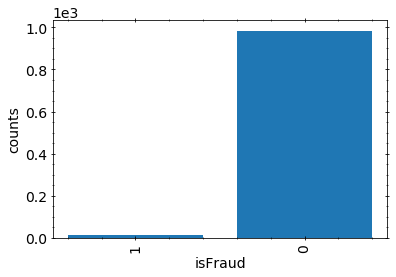

1


In [51]:
JLpyUtils.plot.hist_or_bar(y.head(1000), 
                           categorical_headers= ['isFraud'], n_plot_columns=1)

# Feature Engineering

## Load the Training Set

In [70]:
df = load_df(path_raw_data_dir, train_test_id = 'train')

In [71]:
X = df[headers_dict['features']]
y = df[headers_dict['labels']]

X = basic_feat_cleaner(X)

display(X.head())

del df
gc.collect()
None

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0

## Split Some Text Columns

In [72]:
def cleanup_text_columns(X, headers_dict):
    
    X = X.copy()
    headers_dict = headers_dict.copy()
    
    npartitions = X.npartitions
    X = X.compute()
    
    for header, split_str in [['id_33','x'],
                              ['id_31','/'],
                              ['DeviceInfo','/']]:
        if header in X.columns:
            
            split = X[header].str.split(split_str,expand=True)
            
            for i in range(split.shape[1]):
                
                X[header+'_'+str(i)] = split.iloc[:,0]
            
                if i==0:
                    dtype = X[header+'_'+str(i)].dtype
                
                X[header+'_'+str(i)] = X[header+'_'+str(i)].astype(dtype)
                
                headers_dict['categorical features'] = [feat for feat in headers_dict['categorical features'] if feat!=header]+[header+'_'+str(i)]
            
            X = X.drop(columns=[header])

            headers_dict['categorical features'] = list(dict.fromkeys(headers_dict['categorical features']))
            
    X['id_33_0'] = X['id_33_0'].astype(float)
    X['id_33_1'] = X['id_33_1'].astype(float)
    
    X = dask.dataframe.from_pandas(X, npartitions = npartitions)
    
    return X, headers_dict

In [73]:
X, headers_dict = cleanup_text_columns(X, headers_dict)

X.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_32,id_34,id_35,id_36,id_37,id_38,DeviceType,id_33_0,id_33_1,id_31_0,id_31_1,DeviceInfo_0,DeviceInfo_1,DeviceInfo_2
0,86400,68.50,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,6705385,57.95,W,1906,445.0,150.0,mastercard,224.0,debit,170.0,87.0,5

In [74]:
len(X.columns)

436

In [75]:
len(headers_dict['continuous features']+headers_dict['categorical features'])

436

## Instantiate The Feature Engineering Pipe

The ```JLpyUtils.ML.preprocessing.feat_eng_pipe``` class is designed to streamline & automate running various feature engineering operations. The feature engineering sequence is:
1. BertWord2VecPCA
2. LabelEncode.categorical_features
3. Scale.continuous_features
    * for Scaler_ID in Scalers_dict.keys()
4. Impute.categorical_features
    * for Imputer_cat_ID in Imputer_categorical_dict[Imputer_cat_ID].keys():<br>
        *for Imputer_iter_class_ID in Imputer_categorical_dict[Imputer_cat_ID].keys():
5. Imputer.continuous_features
    * for Imputer_cont_ID in Imputer_continuous_dict.keys():
        * for Imputer_iter_reg_ID in Imputer_continuous_dict[Imputer_cont_ID].keys():
6. OneHotEncode
7. CorrCoeffThreshold

For many of these operations, there are various hyperparameters that could be varied to perform similar but different types of feature engineering. The default settings in the class are setup to allow one to ultimately perform model training on data sets that have different types of scaling, or imputation, etc.. applied. However, for simplicy, and because this dataset is quite large, we will just focus on one feature engineering pipe scenario

In [88]:
importlib.reload(JLpyUtils.ML.NeuralNet.Bert)
importlib.reload(JLpyUtils.ML.preprocessing)
importlib.reload(JLpyUtils.ML.preprocessing._feat_eng_pipe)
importlib.reload(JLpyUtils.ML.preprocessing.Impute)
importlib.reload(JLpyUtils.ML.NeuralNet.Bert)
importlib.reload(JLpyUtils.ML.preprocessing)
importlib.reload(JLpyUtils.ML.preprocessing._feat_eng_pipe)
importlib.reload(JLpyUtils.ML.preprocessing.Impute)


path_feat_eng_dir = os.path.join(path_report_dir,'feat_eng_v2')
feat_eng_pipe = JLpyUtils.ML.preprocessing.feat_eng_pipe(path_feat_eng_dir, 
                                                          verbose=1, 
                                                          overwrite=True)

## Define Single Feature engineering case to evaluate

We could iterate through all possible feature engineering scenarios, but this dataset is quite large and that would take quite a bit of time, so we will just evaluate one promising scenario

In [89]:
import sklearn.preprocessing
import sklearn.linear_model

feat_eng_pipe.Scalers_dict = {'MinMaxScaler': sklearn.preprocessing.MinMaxScaler()}
feat_eng_pipe.Imputer_categorical_dict = {'most_frequent': {None: None}}
feat_eng_pipe.Imputer_continuous_dict = {'median':{None:None}}
feat_eng_pipe.OneHot_cases = [False]
feat_eng_pipe.AbsCorrCoeff_thresholds = [0.99]
feat_eng_pipe.__dict__

{'path_feat_eng_root_dir': '/mr3_boltprod_john_t_leonard/Data_Science_Projects./outputs/Project_Kaggle_IEEE-CIS_Fraud_Detection/feat_eng_v2',
 'verbose': 1,
 'overwrite': True,
 'BertWord2VecPCA_args': {'n_unique_threshold': 20,
  'PCA_vect_length': 20,
  'bert_model_ID': 'bert-base-uncased'},
 'OneHot_cases': [False],
 'Scalers_dict': {'MinMaxScaler': MinMaxScaler(copy=True, feature_range=(0, 1))},
 'Imputer_categorical_dict': {'most_frequent': {None: None}},
 'Imputer_continuous_dict': {'median': {None: None}},
 'AbsCorrCoeff_thresholds': [0.99],
 'save': <function JLpyUtils.file_utils.save(obj, filename, format_, path_dir)>,
 'load': <function JLpyUtils.file_utils.load(filename, format_, path_dir, headers='infer')>}

## Fit Feat Eng Pipe on X

In [90]:
feat_eng_pipe.fit(X.head(n=1000), headers_dict=headers_dict, format_='csv')

-------------------------------- feat_eng_pipe fit --------------------------------
BertWord2VecPCA
Total Progress: 90.909 %. id_31_1 Vectorizing Progress: 100.0 %%0.0 %%

AssertionError: expected 436, but received 531

## Transform X_field using Feat Eng Pipe

We call Kaggle's "test" data "field" data, since usually you actually have labels in the "test" data for machine learning problems, and since we don't actually have access to the labels, it's kinda more like testing our model on field data and getting feedback later on have good or bad it did.

In [82]:
df_field = load_df(path_raw_data_dir, train_test_id = 'test')
X_field = df_field[headers_dict['features']]

X_field = basic_feat_cleaner(X_field)
X_field, headers_dict = cleanup_text_columns(X_field, headers_dict)

del df_field
gc.collect()
None

In [83]:
X_field.columns

Index(['TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2',
       'card3', 'card4', 'card5', 'card6', 'addr1',
       ...
       'id_36', 'id_37', 'id_38', 'DeviceType', 'id_33_0', 'id_33_1',
       'id_31_0', 'DeviceInfo_0', 'DeviceInfo_1', 'DeviceInfo_2'],
      dtype='object', length=435)

In [84]:
for header in X.columns:
    if header not in X_field.columns:
        print(header)

id_31_1


In [86]:
npartitions = X_field.npartitions
X_field = X_field.compute()

X_field['id_31_1'] = np.nan
X_field['id_31_1'] = X_field['id_31_1'].astype(object)

X_field = dask.dataframe.from_pandas(X_field, npartitions= npartitions)

In [87]:
feat_eng_pipe.transform(X_field)

---------------------------- feat_eng_pipe transform ---------------------------
BertWord2VecPCA


/opt/conda/lib/python3.7/socket.py:660: ResourceWarning: unclosed <socket.socket fd=115, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('172.17.0.2', 35846), raddr=('52.216.169.29', 443)>
  self._sock = None


Exception: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample. for DeviceInfo_0

# Model Selection

## Load The Necessary Input Data

In [121]:
feat_eng_case_dir = feat_eng_pipe.path_feat_eng_dirs[0]
feat_eng_case_dir

'/mr3_boltprod_john_t_leonard/Data_Science_Projects./outputs/Project_Kaggle_IEEE-CIS_Fraud_Detection/feat_eng/BertWord2VecPCA/LabelEncode/Scaler_ID[MinMaxScaler]/Imputer_categorical_ID[most_frequent]/Imputer_iterator_classifier_ID[None]/Imputer_continuous_ID[median]/Imputer_iterator_regressor_ID[None]/OneHot_case[False]/CorrCoeffThreshold[0.99]'

In [122]:
X = JLpyUtils.file_utils.load('X','csv', feat_eng_case_dir)

#ensure column headers of formatting appropriate for xgboost
columns_reformatted = [col.replace('[','(').replace(']',')').replace('<','less') for col in X.columns]
X.columns = columns_reformatted

display(X.head())

# ensure X & y have consistant partitions
y = y.repartition(npartitions=X.npartitions)
display(y.head())

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V65,V66,V67,V68,V69,V70,V71,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V107,V110,V111,V112,V114,V115,V116,V117,V118,V119,V120,V121,V123,V124,V125,V126,V127,V129,V130,V131,V132,V133,V135,V136,V138,V139,V140,V141,V142,V143,V144,V145,V146,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V211,V212,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V242,V243,V244,V245,V246,V247,V248,V249,V250,V252,V254,V255,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V290,V291,V292,V293,V294,V295,V297,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_32,id_34,id_35,id_36,id_37,id_38,DeviceType,id_33_0,id_33_1,id_31_1,P_emaildomain_vect0,P_emaildomain_vect1,P_emaildomain_vect2,P_emaildomain_vect3,P_emaildomain_vect4,P_emaildomain_vect5,P_emaildomain_vect6,P_emaildomain_vect7,P_emaildomain_vect8,P_emaildomain_vect9,P_emaildomain_vect10,P_emaildomain_vect11,P_emaildomain_vect12,P_emaildomain_vect13,P_emaildomain_vect14,P_emaildomain_vect15,P_emaildomain_vect16,P_emaildomain_vect17,P_emaildomain_vect18,P_emaildomain_vect19,R_emaildomain_vect0,R_emaildomain_vect1,R_emaildomain_vect2,R_emaildomain_vect3,R_emaildomain_vect4,R_emaildomain_vect5,R_emaildomain_vect6,R_emaildomain_vect7,R_emaildomain_vect8,R_emaildomain_vect9,R_emaildomain_vect10,R_emaildomain_vect11,R_emaildomain_vect12,R_emaildomain_vect13,R_emaildomain_vect14,R_emaildomain_vect15,R_emaildomain_vect16,R_emaildomain_vect17,R_emaildomain_vect18,R_emaildomain_vect19,id_30_vect0,id_30_vect1,id_30_vect2,id_30_vect3,id_30_vect4,id_30_vect5,id_30_vect6,id_30_vect7,id_30_vect8,id_30_vect9,id_30_vect10,id_30_vect11,id_30_vect12,id_30_vect13,id_30_vect14,id_30_vect15,id_30_vect16,id_30_vect17,id_30_vect18,id_30_vect19,id_31_0_vect0,id_31_0_vect1,id_31_0_vect2,id_31_0_vect3,id_31_0_vect4,id_31_0_vect5,id_31_0_vect6,id_31_0_vect7,id_31_0_vect8,id_31_0_vect9,id_31_0_vect10,id_31_0_vect11,id_31_0_vect12,id_31_0_vect13,id_31_0_vect14,id_31_0_vect15,id_31_0_vect16,id_31_0_vect17,id_31_0_vect18,id_31_0_vect19,DeviceInfo_0_vect0,DeviceInfo_0_vect1,DeviceInfo_0_vect2,DeviceInfo_0_vect3,DeviceInfo_0_vect4,DeviceInfo_0_vect5,DeviceInfo_0_vect6,DeviceInfo_0_vect7,DeviceInfo_0_vect8,DeviceInfo_0_vect9,DeviceInfo_0_vect10,DeviceInfo_0_vect11,DeviceInfo_0_vect12,DeviceInfo_0_vect13,DeviceInfo_0_vect14,DeviceInfo_0_vect15,DeviceInfo_0_vect16,DeviceInfo_0_vect17,DeviceInfo_0_vect18,DeviceInfo_0_vect19,DeviceInfo_1_vect0,DeviceInfo_1_vect1,DeviceInfo_1_vect2,DeviceInfo_1_vect3,DeviceInfo_1_vect4,DeviceInfo_1_vect5,DeviceInfo_1_vect6,DeviceInfo_1_vect7,DeviceInfo_1_vect8,DeviceInfo_1_vect9,DeviceInfo_1_vect10,DeviceInfo_1_vect11,DeviceInfo_1_vect12,DeviceInfo_1_vect13,DeviceInfo_1_vect14,DeviceInfo_1_vect15,DeviceInfo_1

,isFraud
0,0
1,0
2,0
3,0
4,0


## Train Test Split

In [123]:
Xy = X.merge(y, left_index = True, right_index=True)

In [124]:
Xy_train, Xy_test = Xy.random_split([0.7, 0.3],
                                random_state=0)

In [125]:
X_train = Xy_train[X.columns]
X_test = Xy_test[X.columns]

y_train = Xy_train[y.columns[0]]
y_test = Xy_test[y.columns[0]]

In [126]:
len(X_train.columns)

522

## Class Balance

In [128]:
y_train.compute().value_counts()

0    59386
1     2008
Name: isFraud, dtype: int64

In [26]:
# to be added at later time

## Train the Models

In [130]:
n_features = len(X.columns)
n_labels = len(y.columns)
models=['xgboost']

models_dict = JLpyUtils.ML.model_selection.default_models_dict.classification(n_features, n_labels, models)
display(models_dict)

{'xgboost': {'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=1, gamma=0,
                learning_rate=0.1, max_delta_step=0, max_depth=3,
                min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
                nthread=None, objective='binary:logistic', random_state=0,
                reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                silent=None, subsample=1, tree_method='gpu_hist', verbosity=1),
  'param_grid': {'max_depth': [3, 10],
   'learning_rate': [0.01, 0.1, 1],
   'n_estimators': [10, 100, 1000],
   'subsample': [1.0, 0.9, 0.5],
   'colsample_bytree': [1.0, 0.8, 0.5]}}}

In [132]:
path_BayesianSearchCV_dir = os.path.join(feat_eng_case_dir,'BayesianSearchCV')
print(path_BayesianSearchCV_dir)

/mr3_boltprod_john_t_leonard/Data_Science_Projects./outputs/Project_Kaggle_IEEE-CIS_Fraud_Detection/feat_eng/BertWord2VecPCA/LabelEncode/Scaler_ID[MinMaxScaler]/Imputer_categorical_ID[most_frequent]/Imputer_iterator_classifier_ID[None]/Imputer_continuous_ID[median]/Imputer_iterator_regressor_ID[None]/OneHot_case[False]/CorrCoeffThreshold[0.99]/BayesianSearchCV


In [133]:
import sklearn.metrics

In [142]:
importlib.reload(JLpyUtils.ML.model_selection)
importlib.reload(JLpyUtils.ML.model_selection._search)
importlib.reload(JLpyUtils.ML.model_selection)
importlib.reload(JLpyUtils.ML.model_selection._search)

metrics={'roc_auc': sklearn.metrics.roc_auc_score,
         'accuracy':sklearn.metrics.accuracy_score,
         'precision':sklearn.metrics.precision_score,
         'recall':sklearn.metrics.recall_score,
         'f1_score':sklearn.metrics.f1_score}

BayesianSearchCV = JLpyUtils.ML.model_selection.BayesianSearchCV(models_dict,
                                                             cv=4, 
                                                             scoring={'metric': 'roc_auc',
                                                                      'maximize': True}, 
                                                             metrics=metrics, 
                                                             retrain=True, 
                                                             path_BayesianSearchCV_dir=path_BayesianSearchCV_dir, 
                                                             verbose=2)

In [ ]:
BayesianSearchCV.fit(X_train, y_train, X_test, y_test, max_evals=1000)


---- xgboost ----
path_model_dir: /mr3_boltprod_john_t_leonard/Data_Science_Projects./outputs/Project_Kaggle_IEEE-CIS_Fraud_Detection/feat_eng/BertWord2VecPCA/LabelEncode/Scaler_ID[MinMaxScaler]/Imputer_categorical_ID[most_frequent]/Imputer_iterator_classifier_ID[None]/Imputer_continuous_ID[median]/Imputer_iterator_regressor_ID[None]/OneHot_case[False]/CorrCoeffThreshold[0.99]/BayesianSearchCV/xgboost
Fitting 4 folds for each of 1000 candidates, totalling 4000 fits
  1%|▏         | 14/1000 [26:39<30:24:55, 111.05s/it, best loss: 2.005400354013306]

# Model Inspection

## Feature Importance

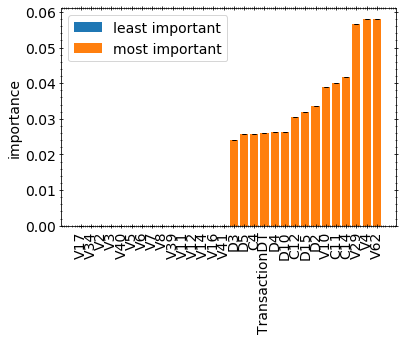

In [85]:
importlib.reload(JLpyUtils.ML.inspection.plot)
JLpyUtils.ML.inspection.plot.feature_importance(model, 'xgboost', 
                                                feature_headers=list(X.columns[:100]),
                                                rect = (0,0,1.5,2))

In [ ]:
%%time
y_pred = model.predict(X_test).compute()

y_pred_proba = model.predict_proba(X_test).compute()

In [ ]:
%%time

import sklearn.metrics

roc_auc = sklearn.metrics.roc_auc_score(y_test, y_pred_proba)
print(roc_auc)